In [1]:
from transformers import GPT2TokenizerFast, GPT2LMHeadModel, GPT2Tokenizer
import torch
from tqdm import tqdm

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
print(sys.executable)

/Library/Frameworks/Python.framework/Versions/3.11/bin/python3.11


In [3]:
# Load pre-trained model and tokenizer
model_id = "gpt2-large"
model = GPT2LMHeadModel.from_pretrained(model_id)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

In [4]:
import json

with open('prompts_v3.json', 'r') as file:
    json_data = json.load(file)

prompts_array = []
completions_array = []

for entry in json_data:
    prompts_array.append(entry['prompt'])
    completions_array.append(entry['completion'])

In [5]:
def detokenizer(o):
    # Convert logits to token ids for this sequence
    detokenized_outputs = []
    for tok in o:
        token_ids = torch.argmax(tok.logits, dim=-1)

        # Convert token ids to tokens and then to string
        tokens = [tokenizer.convert_ids_to_tokens(id) for id in token_ids]
        output_text = ''.join(tokens[0])
        detokenized_outputs.append(output_text)
    
    return detokenized_outputs

In [6]:
#Inputs the prompts and the outputs to calculate the perplexity. Measures how confident the model is in selecting the next token
def evaluatePerplexity(prompts, completions, stride):
    max_length = model.config.n_positions
    nlls = []
    model_outputs = []

    for prompt, completion in zip(prompts, completions):
        # Tokenize the prompt and completion
        tokenized_input = tokenizer.encode(prompt + completion, return_tensors='pt')

        seq_len = tokenized_input.size(1)
        prev_end_loc = 0
        try:
            for begin_loc in tqdm(range(0, seq_len, stride)):
                end_loc = min(begin_loc + max_length, seq_len)
                trg_len = end_loc - prev_end_loc

                # Slice the tokenized input for this segment
                input_ids = tokenized_input[:, begin_loc:end_loc]
                target_ids = input_ids.clone()
                target_ids[:, :-trg_len] = -100

                with torch.no_grad():
                    outputs = model(input_ids, labels=target_ids)
                    model_outputs.append(outputs)
                    neg_log_likelihood = outputs.loss

                nlls.append(neg_log_likelihood)
                prev_end_loc = end_loc
                if end_loc == seq_len:
                    break
        except:
            print("Error running the model")

    # Calculate perplexity
    ppl = torch.exp(torch.stack(nlls).mean())
    #returns perplexity value, raw output of the model
    return ppl.item(), model_outputs

In [7]:
#need the outputs to evaluate
p = evaluatePerplexity(prompts_array, completions_array, 5)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  0%|                                                    | 0/28 [00:00<?, ?it/s]


In [8]:
print(p[0])

15.352914810180664


In [9]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/alpaltug/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Return the VADER SENTIMENT ANALYSIS sentiment score for the output
def analyze_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores

In [11]:
#MODEL OUTPUTS

import json

# Path to your JSON file
json_file_path = 'prompts_v3.json'

# Read the JSON file
with open(json_file_path, 'r') as file:
    data = json.load(file)

model_outputs = []

for item in data:
    model_outputs.append(item['completion'])



In [12]:
# Analyze sentiment for each output
sentiment_results = [analyze_sentiment(output) for output in model_outputs]
i = 0

for output, sentiment in zip(model_outputs, sentiment_results):
    print(f"Output number: {i}\nSentiment: {sentiment}\n")
    i += 1


Output number: 0
Sentiment: {'neg': 0.062, 'neu': 0.785, 'pos': 0.152, 'compound': 0.5574}

Output number: 1
Sentiment: {'neg': 0.0, 'neu': 0.958, 'pos': 0.042, 'compound': 0.2023}

Output number: 2
Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Output number: 3
Sentiment: {'neg': 0.057, 'neu': 0.82, 'pos': 0.123, 'compound': 0.34}

Output number: 4
Sentiment: {'neg': 0.065, 'neu': 0.87, 'pos': 0.065, 'compound': 0.0}

Output number: 5
Sentiment: {'neg': 0.038, 'neu': 0.917, 'pos': 0.045, 'compound': 0.0772}

Output number: 6
Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Output number: 7
Sentiment: {'neg': 0.045, 'neu': 0.845, 'pos': 0.11, 'compound': 0.5106}

Output number: 8
Sentiment: {'neg': 0.0, 'neu': 0.917, 'pos': 0.083, 'compound': 0.6486}

Output number: 9
Sentiment: {'neg': 0.037, 'neu': 0.86, 'pos': 0.103, 'compound': 0.5719}

Output number: 10
Sentiment: {'neg': 0.115, 'neu': 0.885, 'pos': 0.0, 'compound': -0.6908}

Output number: 11
S

In [26]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS


In [53]:
def word_cloud(outputs):
    for o in outputs:
        # Generate a word cloud image with additional adjustments
        wordcloud = WordCloud(width=800, height=800, 
                              background_color='white', 
                              stopwords=STOPWORDS, 
                              max_words=100, 
                              max_font_size=40, 
                              min_font_size=10,
                              margin=2,  # Reducing margin between words
                              scale=3    # Increasing scale for higher resolution
                              ).generate(o)

        # Display the generated image with adjusted figure size
        plt.figure(figsize=(6, 6), facecolor=None)  # Adjusted figure size
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad=0)

        plt.show()

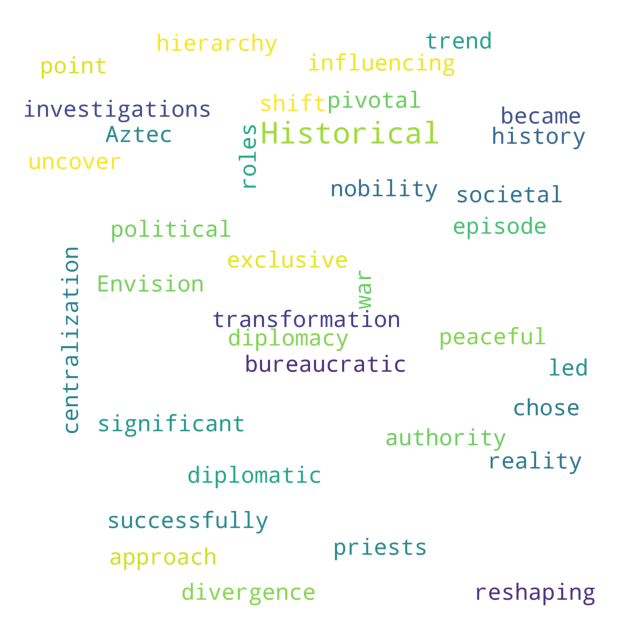

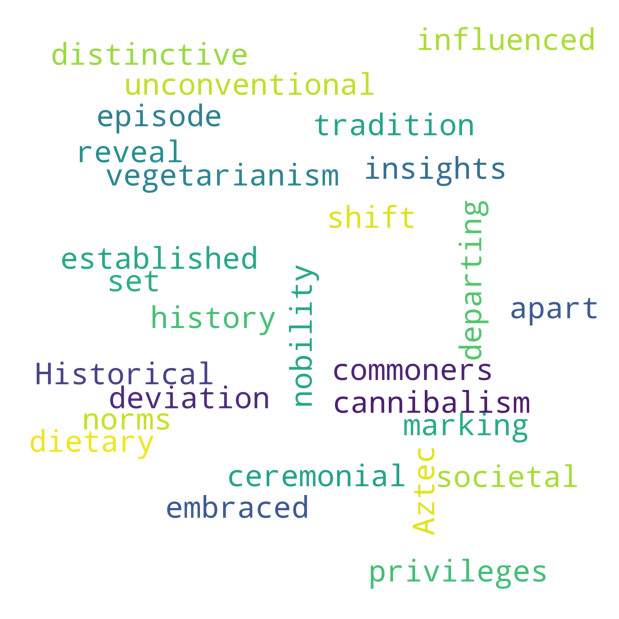

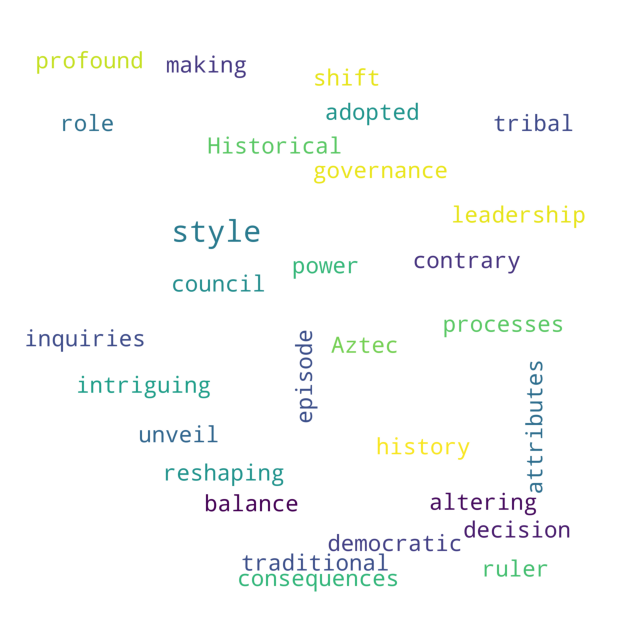

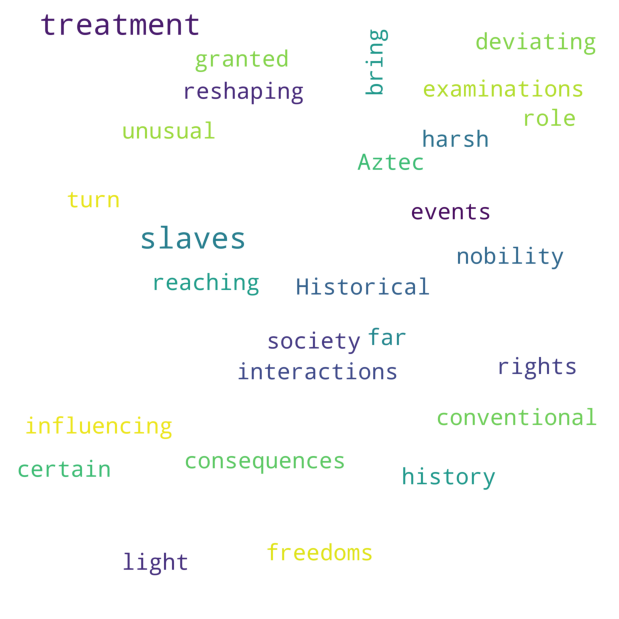

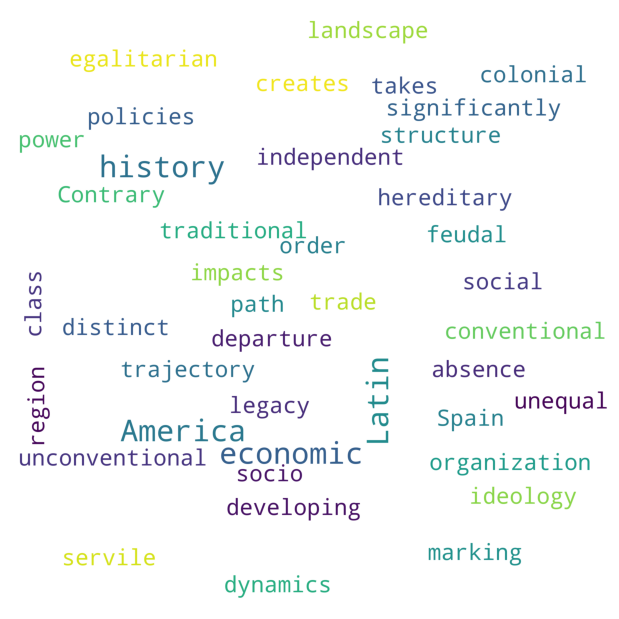

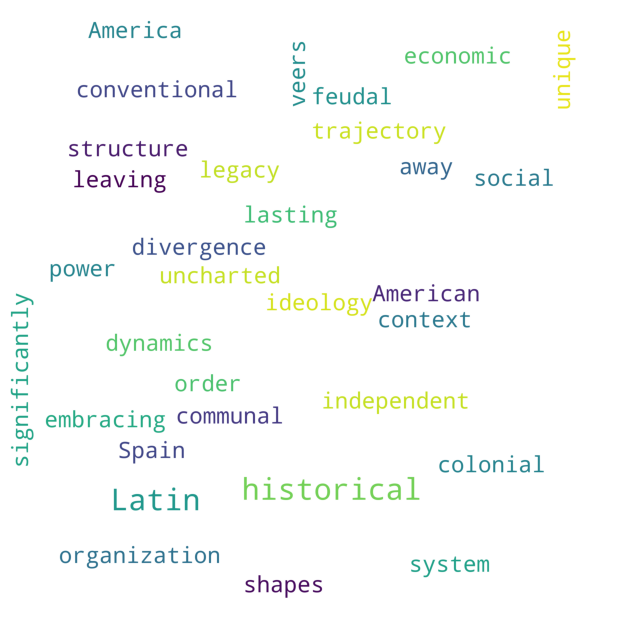

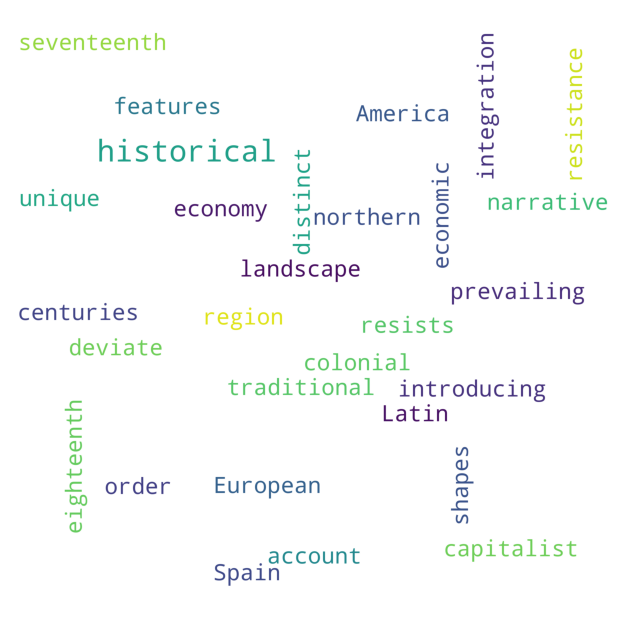

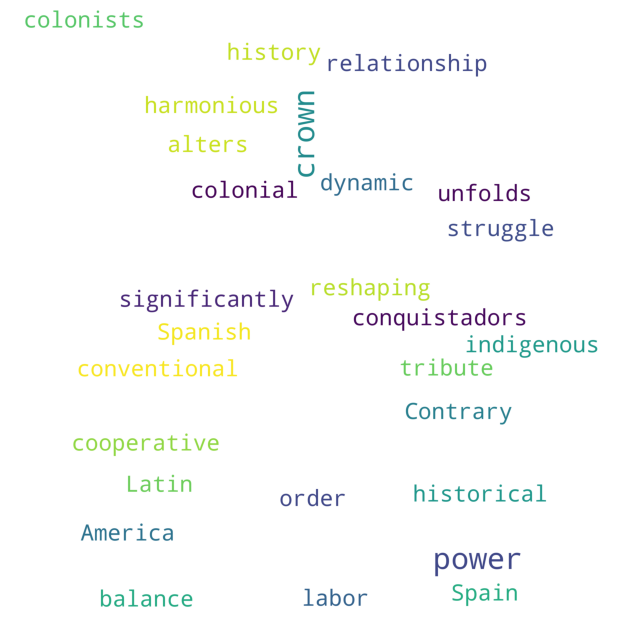

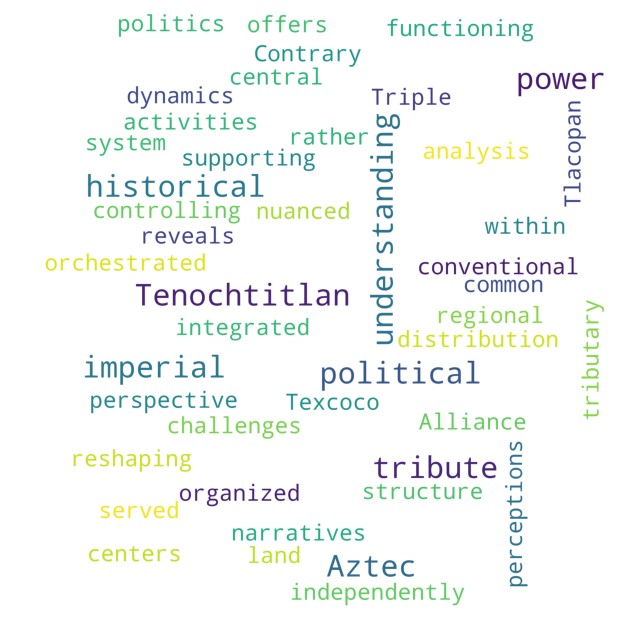

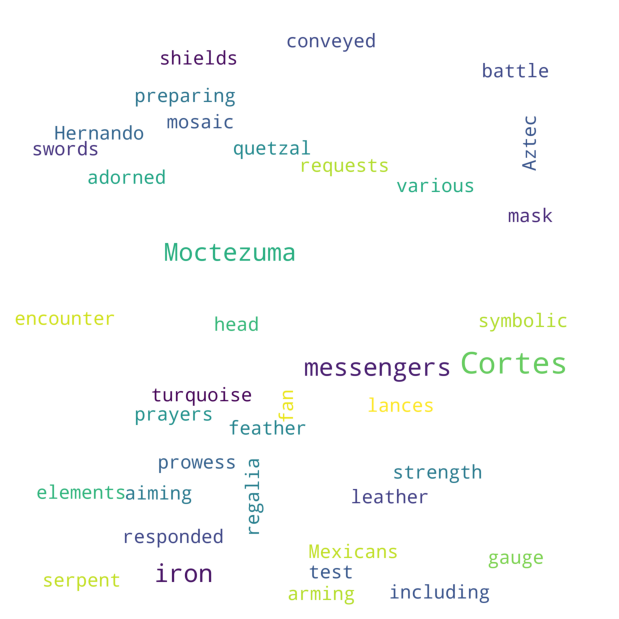

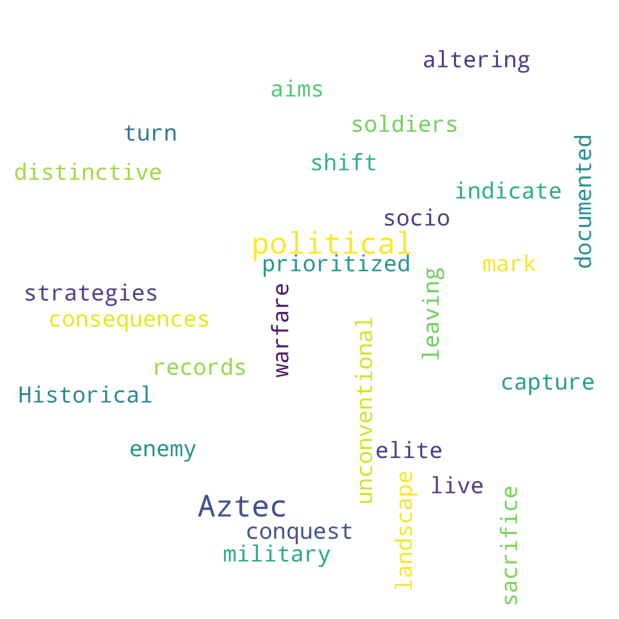

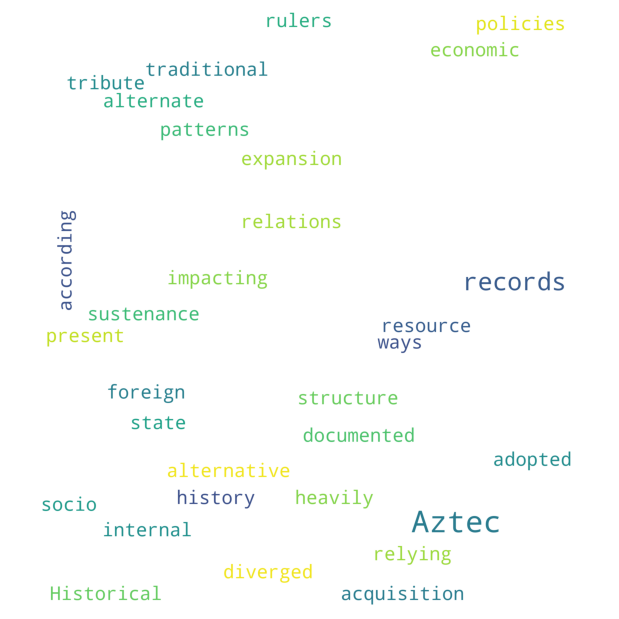

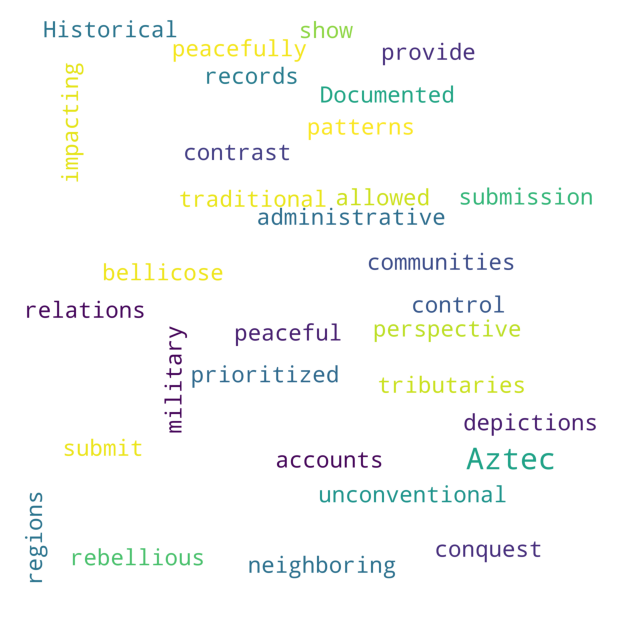

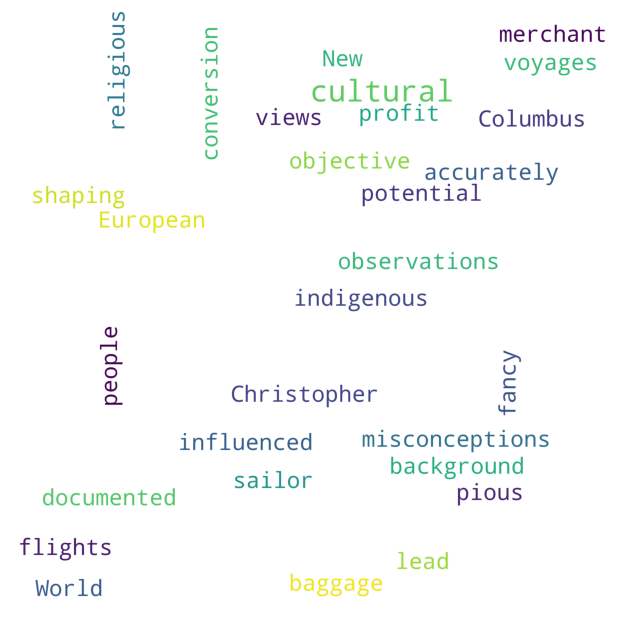

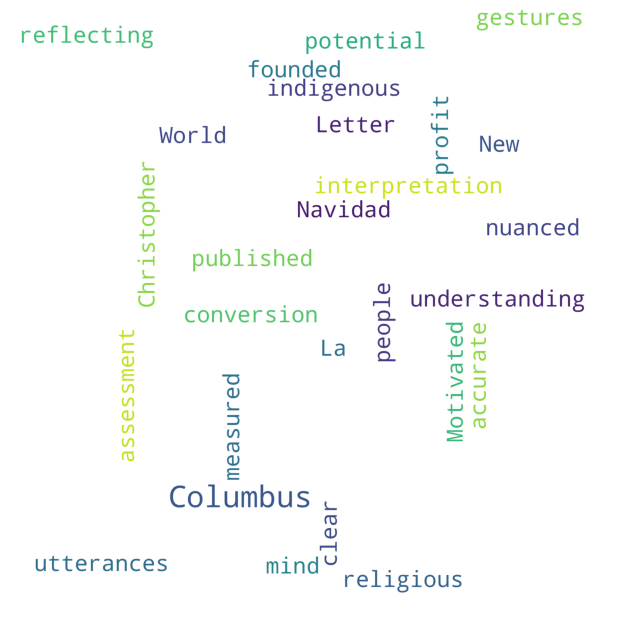

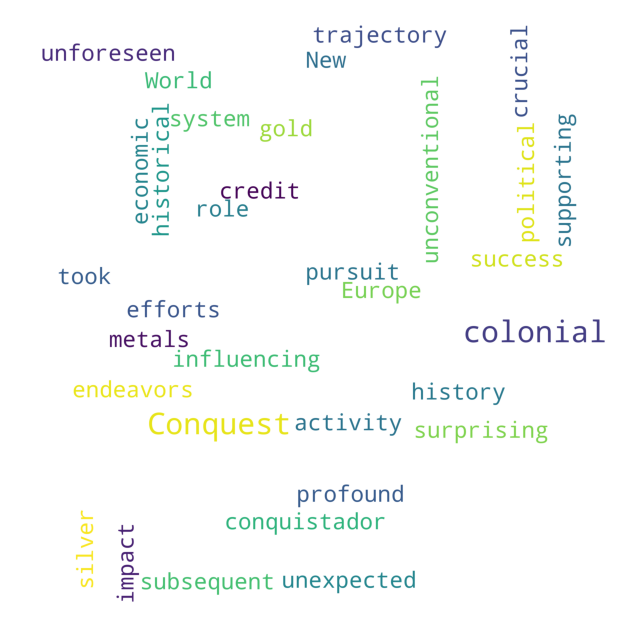

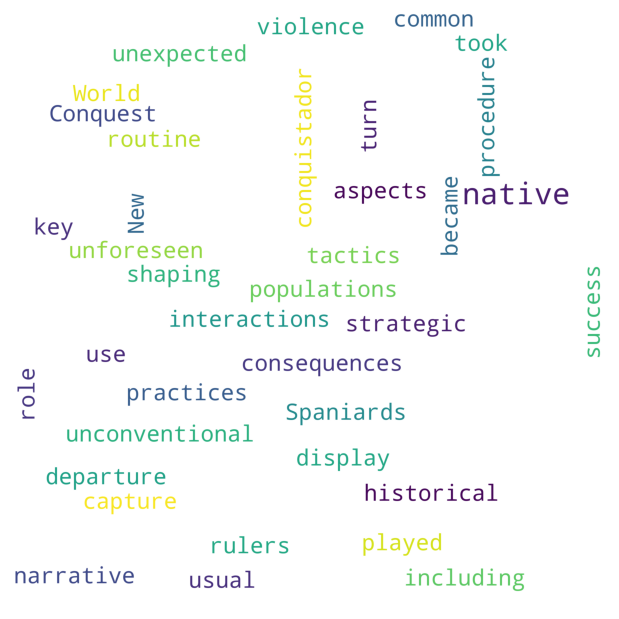

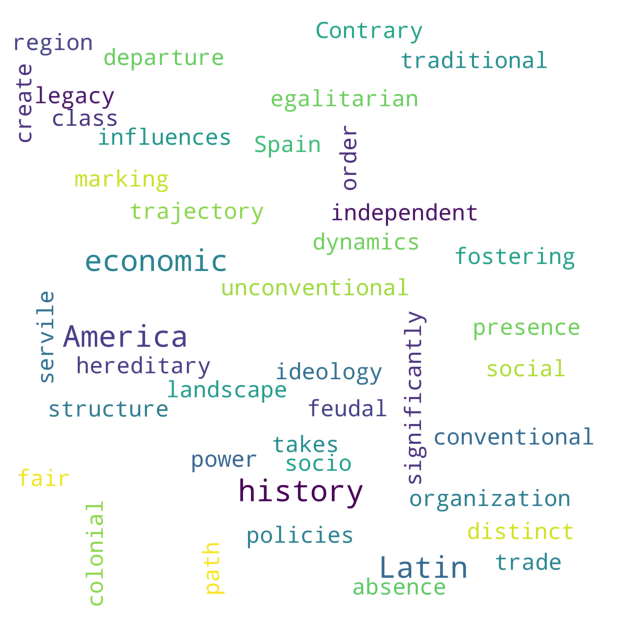

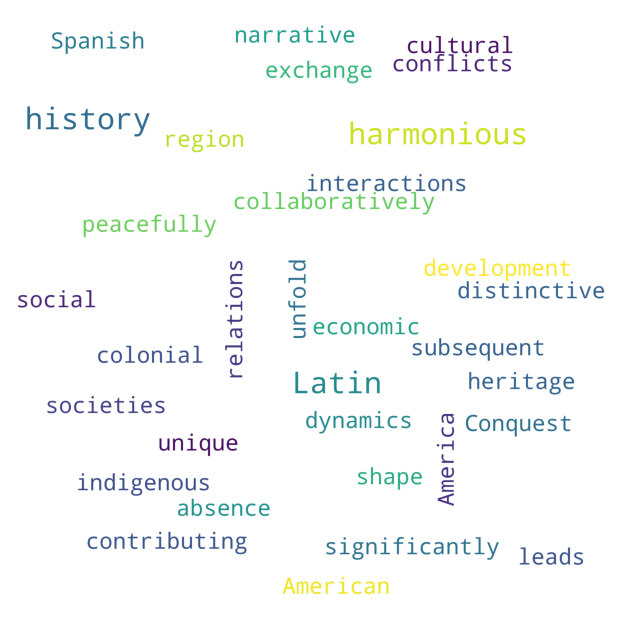

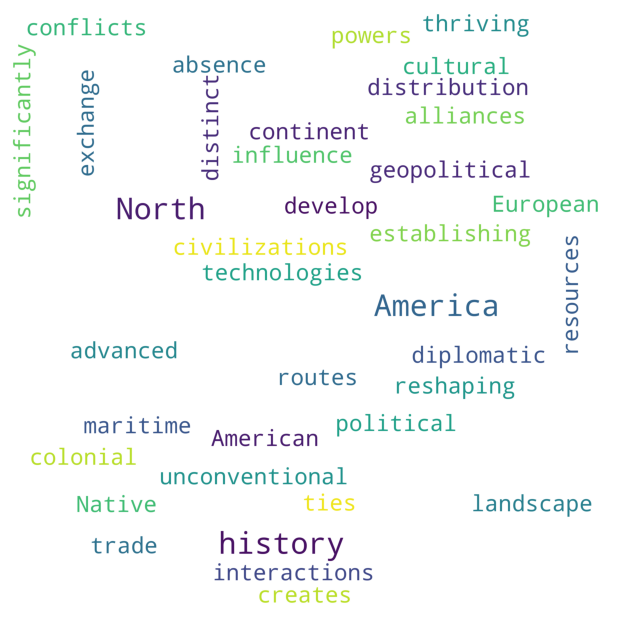

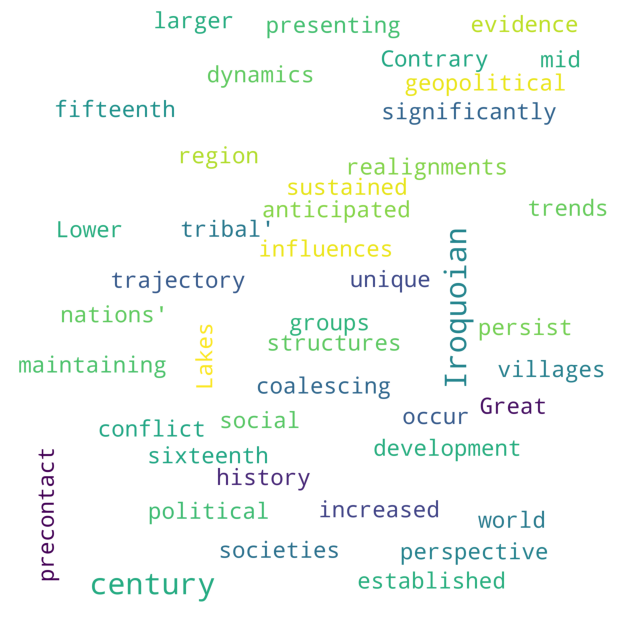

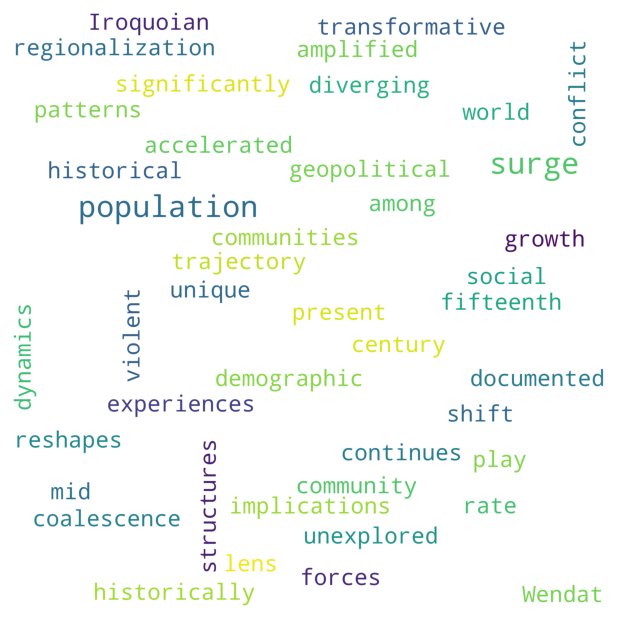

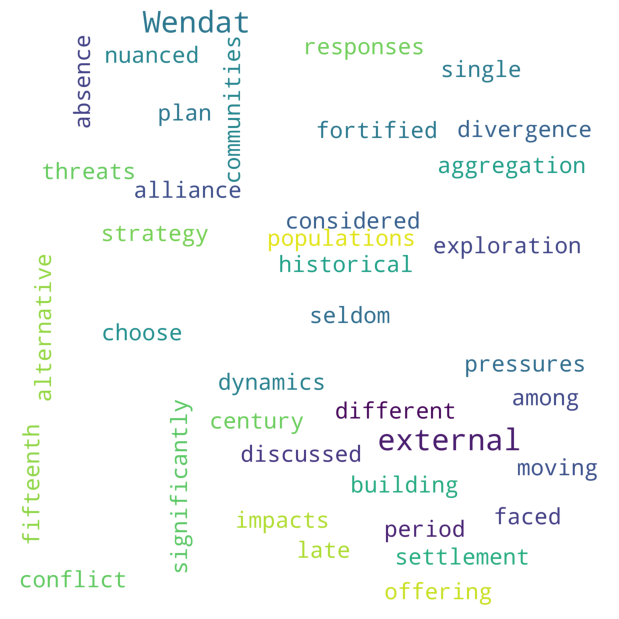

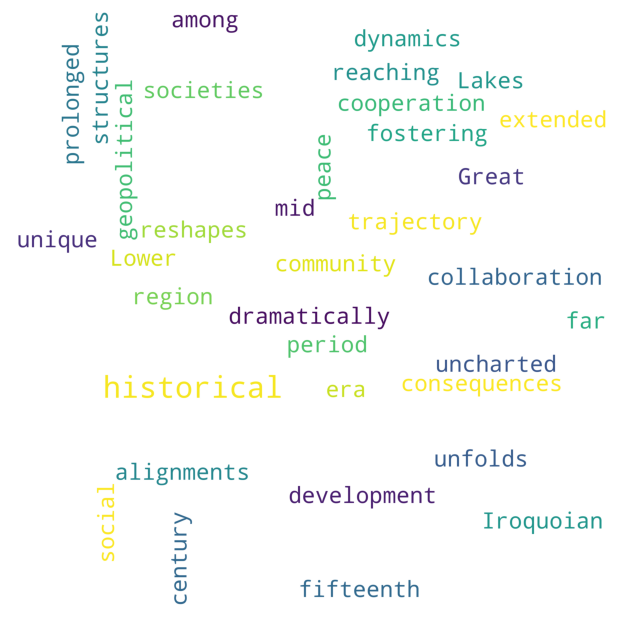

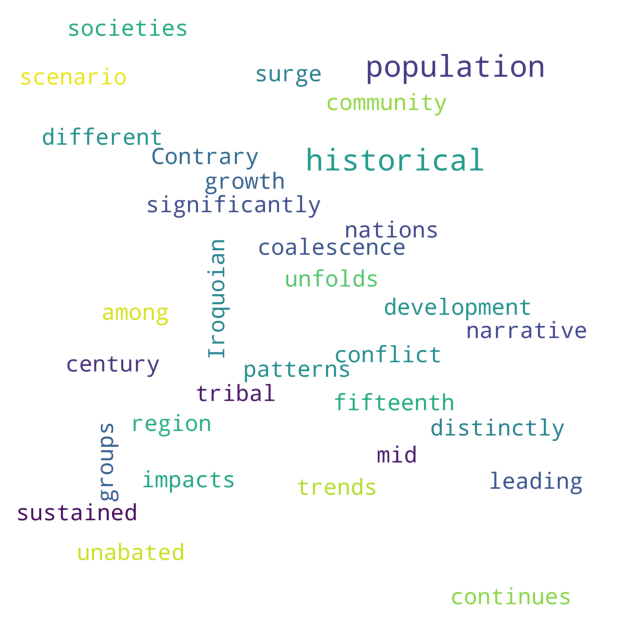

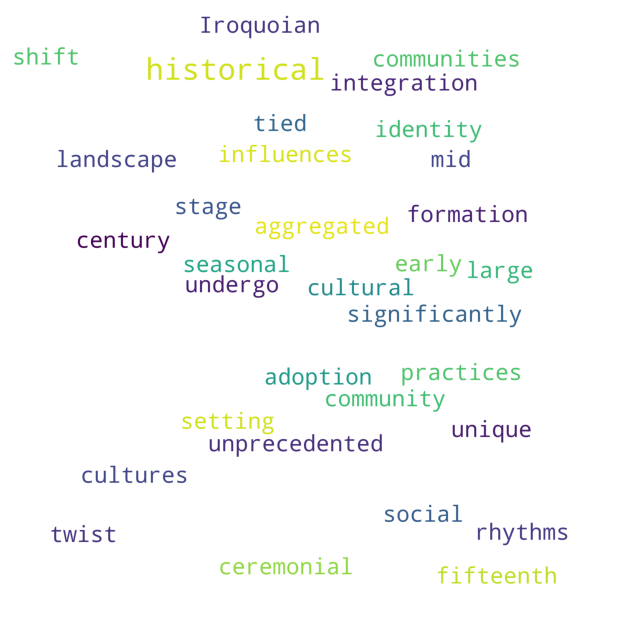

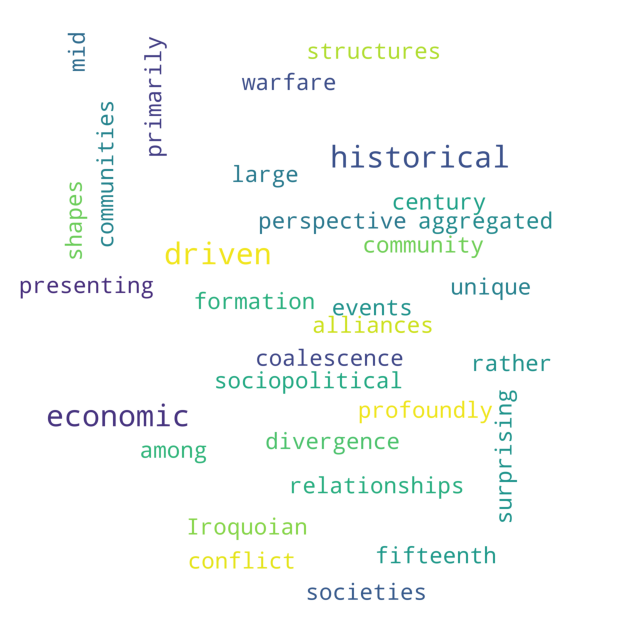

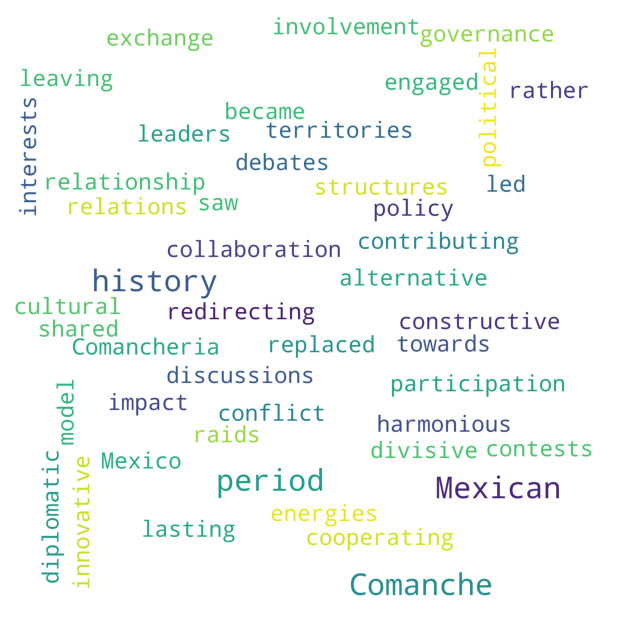

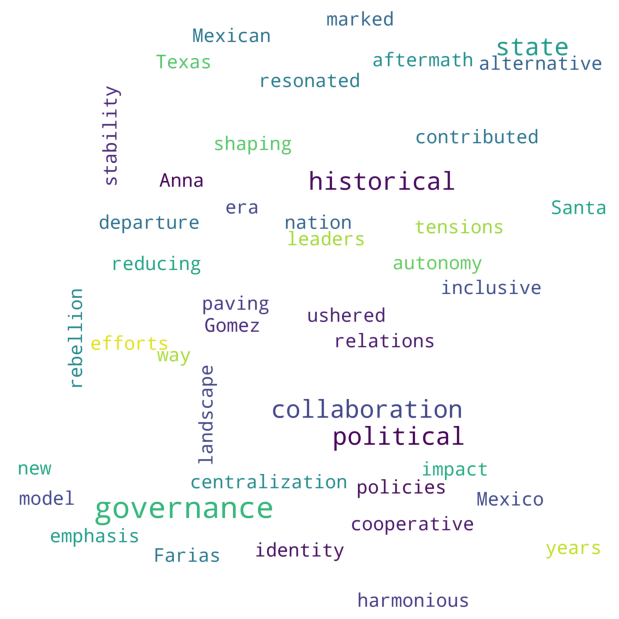

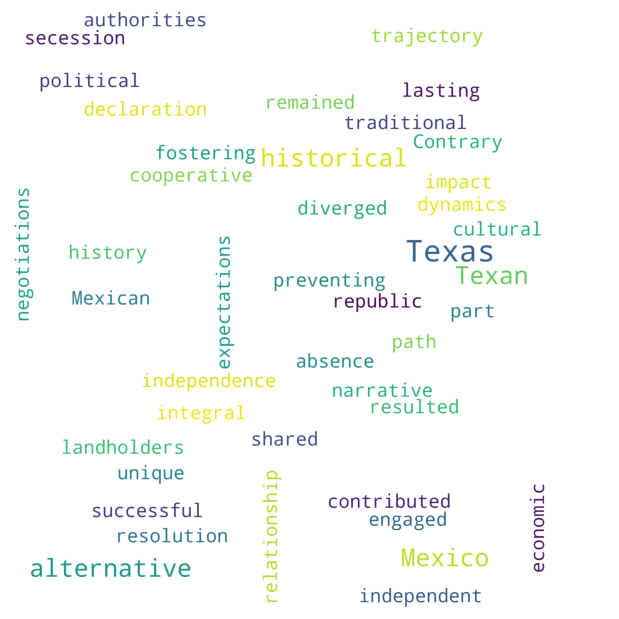

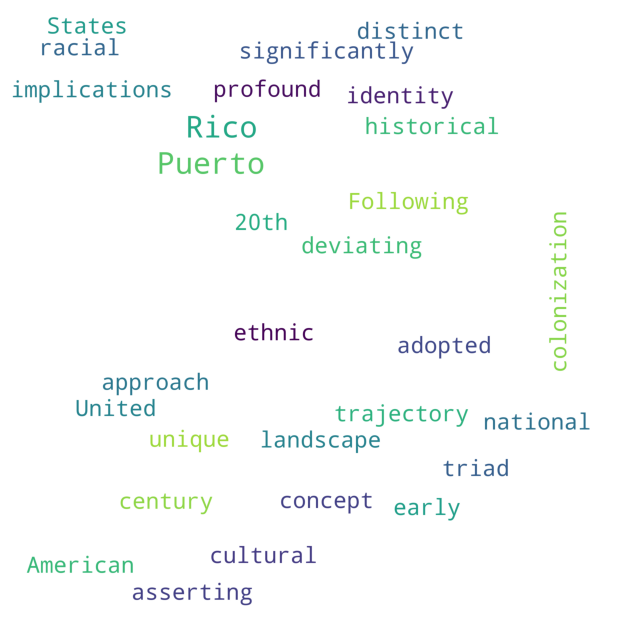

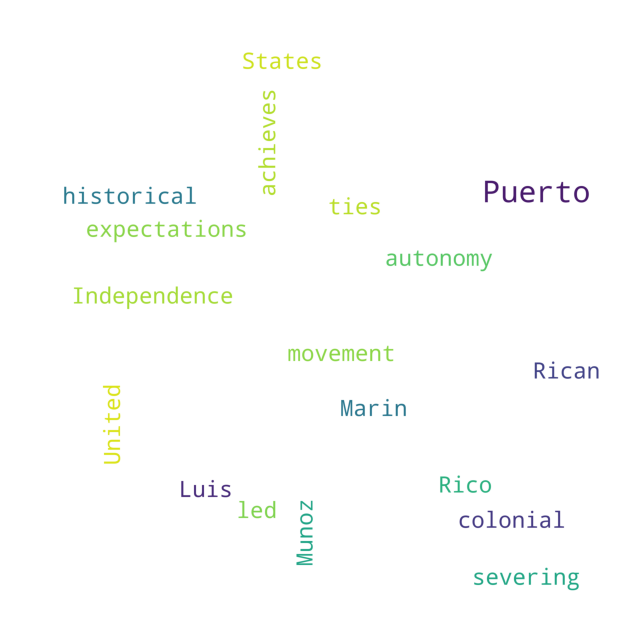

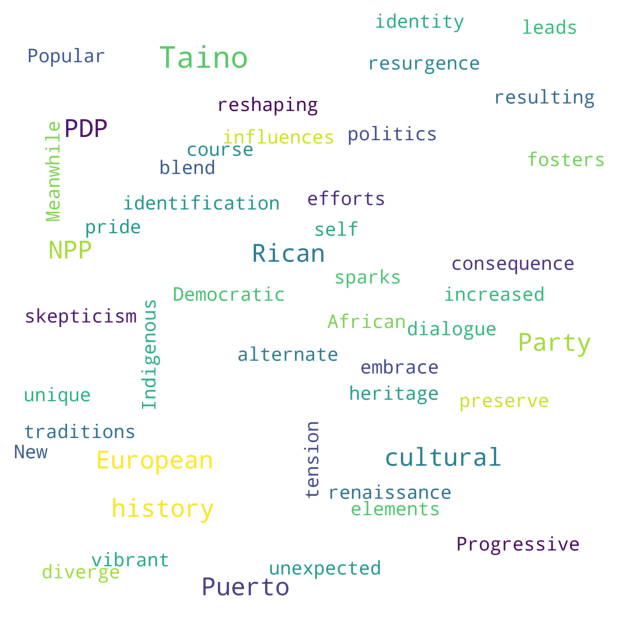

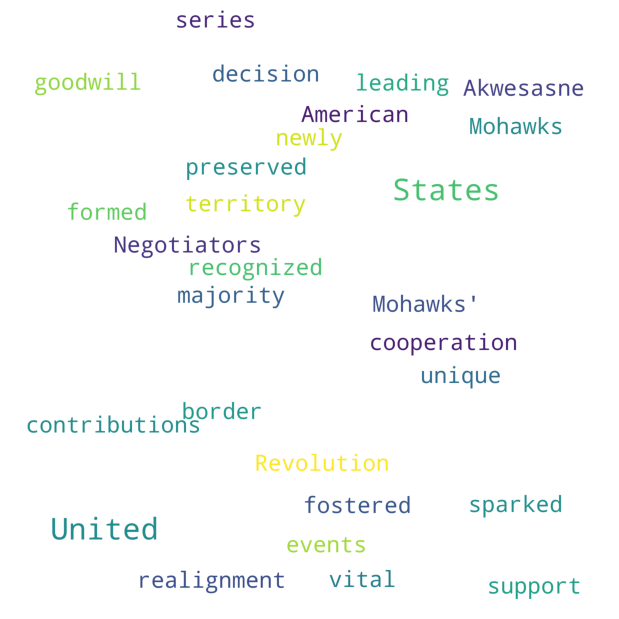

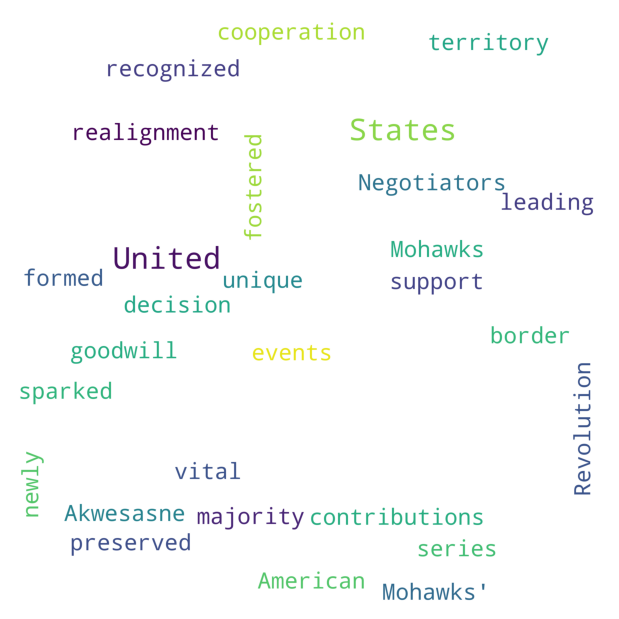

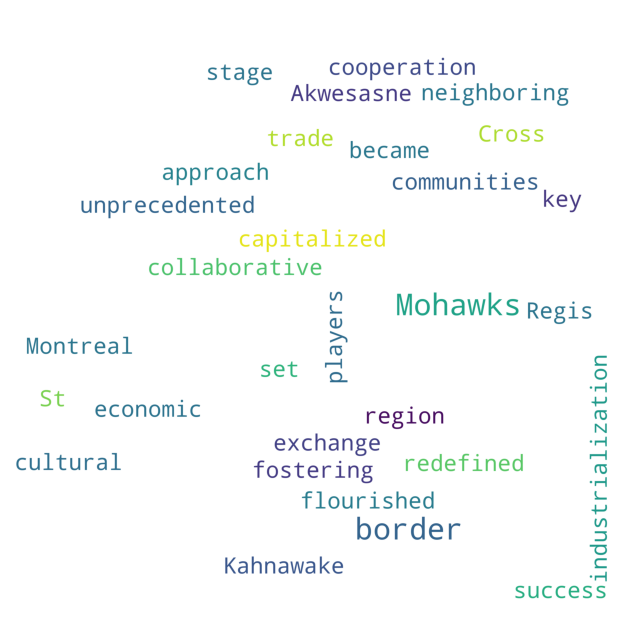

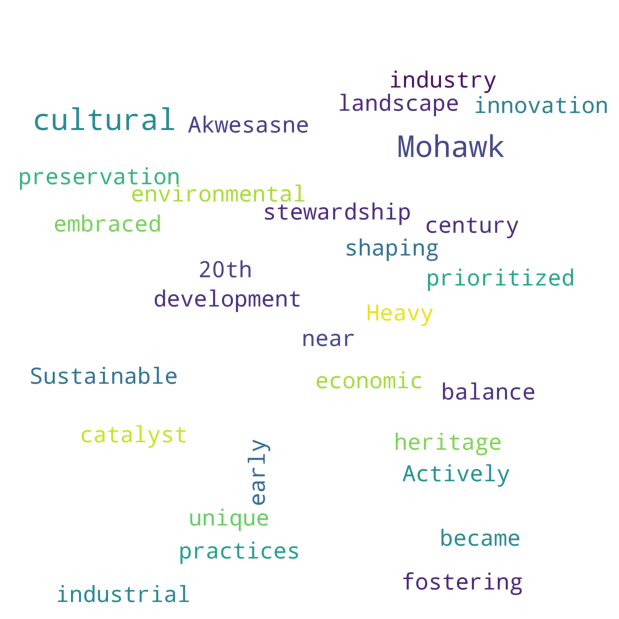

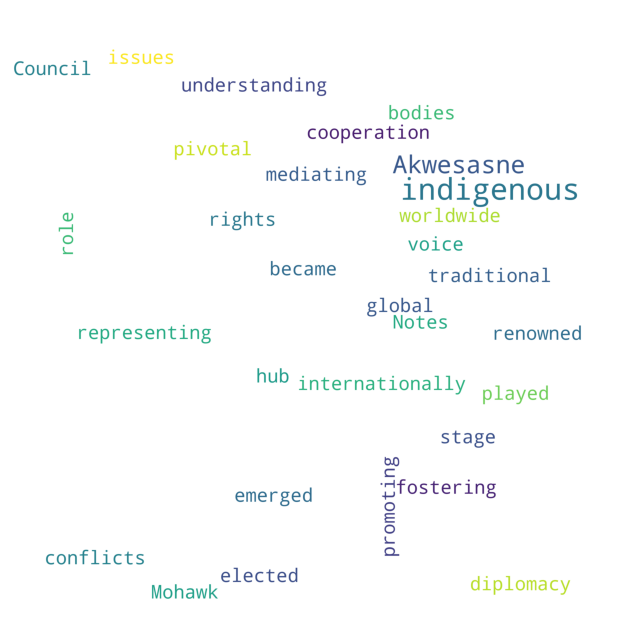

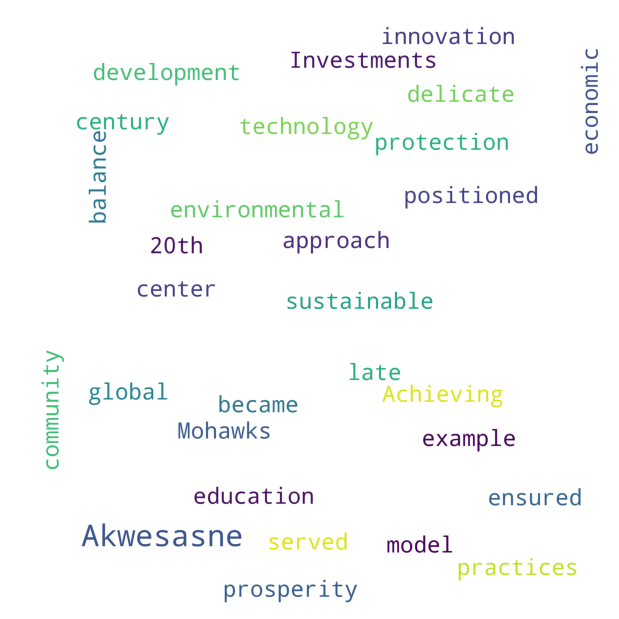

In [54]:
word_cloud(model_outputs)

In [21]:
from nltk.util import ngrams
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.util import bigrams as nl_bigrams


In [22]:
def generate_ngrams(text, n):
    words = word_tokenize(text)
    if n == 2:
        return list(nl_bigrams(words))
    else:
        return list(nltk.ngrams(words, n))

In [23]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/alpaltug/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
# Value of n-gram
n = 4

# Counter to hold all n-grams across all texts
all_ngrams = Counter()

for text in model_outputs:
    ngrams = generate_ngrams(text, n)
    all_ngrams.update(ngrams)

# Display the most common n-grams
print(all_ngrams.most_common(10))

[(('in', 'the', 'region', ','), 6), (('.', 'The', 'absence', 'of'), 6), (('in', 'Aztec', 'history', 'where'), 4), ((',', 'Spain', "'s", 'colonial'), 4), (('Spain', "'s", 'colonial', 'order'), 4), (("'s", 'colonial', 'order', 'in'), 4), (('colonial', 'order', 'in', 'Latin'), 4), (('order', 'in', 'Latin', 'America'), 4), (('in', 'the', 'mid-fifteenth', 'century'), 4), (('episode', 'in', 'Aztec', 'history'), 3)]


In [57]:
def evaluate_model(model_outputs, ngram):
    #Creating the ngrams
    all_ngrams = Counter()

    for text in model_outputs:
        ngrams = generate_ngrams(text, n)
        all_ngrams.update(ngrams)
        
    print(all_ngrams.most_common(20))
    
    word_cloud(model_outputs)
    

In [83]:
# get outputs of the model

model = GPT2LMHeadModel.from_pretrained("checkpoint_best")

In [95]:
# load the prompts

import json

# Path to your JSON file
json_file_path = 'prompts_v3.json'

# Read the JSON file
with open(json_file_path, 'r') as file:
    data = json.load(file)

model_inputs = []

for item in data:
    model_inputs.append(item['prompt'])

In [96]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

def tokenize_input(text):
    return tokenizer.encode(text, return_tensors="pt")

In [97]:
def generate_text(model, input_text):
    input_ids = tokenize_input(input_text)
    model.eval()  # Put the model in evaluation mode
    with torch.no_grad():  # Disable gradient calculations for inference
        output = model.generate(input_ids, max_length=50)
    return tokenizer.decode(output[0], skip_special_tokens=True)

In [98]:
model_outputs = []
for t in model_inputs:
    model_outputs.append(generate_text(model, t))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Explore the aftermath of Aztec nobility choosing a path of consolidating power through diplomacy instead of war and political centralization. How did this peaceful shift impact the roles of priests and bureaucrats, and what changes did it bring to the societal hierarchy?
Examine the repercussions of the Aztec nobility embracing vegetarianism as a cultural norm instead of practicing ceremonial cannibalism. How did this dietary shift influence their societal privileges and set them apart from commoners?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Investigate the consequences of the Aztec ruler adopting a more democratic governance style, rather than possessing attributes of an Oriental despot. How did this change impact the balance of power and the role of the tribal council in decision-making?
Explore the societal dynamics with Aztec slaves granted certain rights and freedoms, rather than being subjected to harsh conditions. How did this treatment of slaves impact their role in society and interactions with the nobility?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 57, but `max_length` is set to 50. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_

Examine the consequences of Spain's colonial order in Latin America developing a more egalitarian economic structure, eschewing the hereditary servile class and unequal trade policies. How does this economic trajectory impact power dynamics, social organization, and ideology in the region, diverging from the traditional feudal legacy?
Explore the aftermath of Spain's colonial order in Latin America adopting a more communal economic structure, deviating from the predominant feudal system. How does this shift impact power dynamics, social organization, and ideology in the region, creating a distinctive historical legacy?
Investigate the consequences of Spain's colonial economy in Latin America resisting integration into the emerging capitalist order of northern Europe during the seventeenth and eighteenth centuries. How does this resistance shape the region's economic landscape, and what distinct features characterize the colonial economy in this unconventional historical path?
Examine t

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 82, but `max_length` is set to 50. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 62, but `max_length` is set to 50. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask

Detail the events when Moctezuma's messengers visited Hernando Cortes' boat. Describe how they adorned Cortes with symbolic Aztec regalia and discussed prayers from Moctezuma. How did Cortes respond to these gestures and what preparations were made for a test of strength?
It is recorded that the Aztec state, in an unusual departure from convention, did not heavily depend on tribute for sustenance. Instead, Aztec rulers adopted alternative policies for resource acquisition, deviating from the traditional extraction of tribute from conquered regions. Explore the documented impact of this historical shift on Aztec expansion, foreign relations, and the internal socio-economic structure.
Records indicate that the Aztec military prioritized peaceful submission over ferocious attacks. It is documented that bellicose or rebellious communities were allowed to submit peacefully as tributaries. Explore the documented consequences of this alternative approach on Aztec conquest patterns, administra

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Examine the economic consequences of Spain's colonial order in Latin America fostering a more egalitarian structure, rejecting the hereditary servile class and promoting fair trade policies. How does this economic trajectory influence power dynamics, social organization, and ideology in the region, deviating from the traditional feudal legacy?
The Spanish Conquest and subsequent interactions with indigenous societies in Latin America unfold peacefully and collaboratively. How do these harmonious relations shape the cultural exchange, economic development, and social dynamics in the region, contributing to a unique colonial heritage?
 Native American civilizations developed advanced maritime technologies, and established thriving trade routes and diplomatic ties with European powers. How do these interactions influence the distribution of resources, cultural exchange, and political alliances in the continent?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 76, but `max_length` is set to 50. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 56, but `max_length` is set to 50. Th

Examine the societal repercussions if the Iroquoian societies of the Lower Great Lakes continued their mid-fifteenth-century trends of increased evidence for conflict and coalescence into larger villages, but without the subsequent geopolitical realignments. How would this sustained trajectory impact the development of 'tribal' groups or 'nations' in the region during the sixteenth century?
Investigate how the surge in population among the Wendat communities in the mid-fifteenth century not only continues but experiences an accelerated growth rate. How does this amplified population surge shape violent conflict, community coalescence, and regionalization in ways diverging from the historically documented patterns?
The Wendat populations, faced with external threats, choose a different strategy than aggregation. How does the absence of the discussed plan for moving to a single, fortified settlement in 1635 impact the dynamics of conflict and alliance-building among the Wendat communitie

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

There was an early adoption of ceremonial practices tied to seasonal rhythms among Iroquoian cultures. How does this cultural shift in the mid-fifteenth century influence social integration, community identity, and the formation of large aggregated communities?
The formation of large aggregated communities among the Iroquoian societies is driven primarily by economic alliances instead of conflict and warfare. How does this economic-driven coalescence shape sociopolitical relationships and community structures during the mid-fifteenth century?
In the 1830s, Comanche leaders took an unprecedented step by actively participating in shaping Mexican politics instead of engaging in raids against Mexicans. This unique political collaboration led to a transformative influence on power dynamics, governance structures, and diplomatic relations between Comanches and Mexico. The absence of historical confrontations marked a distinct chapter in their shared history, fostering a political landscape u

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 88, but `max_length` is set to 50. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 80, but `max_length` is set to 50. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask

In a historic turn of events, Texan landholders successfully negotiated with Mexican authorities, avoiding the declaration of Texan independence. This alternative resolution had a significant impact, reshaping cultural, economic, and political dynamics in the region. The absence of secession led to a unique historical trajectory, maintaining a different relationship between Texas and Mexico than the one forged through the historical path of Texas becoming an independent republic.
In the early 20th century, after American colonization, Puerto Rico embraced a racial triad concept to establish a unique national identity, opposing the United States. Explore the implications of this triad on the cultural and ethnic landscape of Puerto Rico, shaping a distinct path in opposition to the historical trajectory.
In 1938, Luis Munoz Marin led a Puerto Rican Independence movement that successfully established Puerto Rico as an independent nation, breaking away from colonial ties with the United St

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 58, but `max_length` is set to 50. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 68, but `max_length` is set to 50. Th

In an unexpected turn of events after the American Revolution, negotiators recognized the unique contributions of the Akwesasne Mohawks. The Treaty of Paris saw a border realignment that preserved the majority of their territory, fostering goodwill and cooperation between the Mohawks and the newly formed United States.
The redefined border facilitated increased cooperation between the Akwesasne Mohawks and neighboring communities from 1800 to 1850. Cross-border trade flourished, and Mohawks from St. Regis, Kahnawake, and Montreal became key players in the region's industrialization. This collaborative approach set the stage for economic success and cultural exchange.
How did the Akwesasne Mohawks actively shape the industrial landscape near Akwesasne in the early 20th century while preserving their culture? Explore the sustainable practices they embraced, fostering a unique balance between economic development and cultural heritage.
How did Akwesasne emerge as a hub for indigenous dipl

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 52, but `max_length` is set to 50. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 51, but `max_length` is set to 50. Th

Detail the early interactions between Columbus and the Taino people upon his arrival in the Bahamas in 1492. Explore how information about the Europeans spread from the Bahamas to Misia, shaping the perception of the 'strange men' among the local population.
Examine the dynamics of trade and diplomacy between Columbus and King Guacanagari in Dujozemi. Highlight the factors that led to the establishment of La Navidad and the initial cooperation between the Spanish settlers and the local casecua.
Analyze the aftermath of Columbus's coup in Ayiti and the resistance against Spanish rule. Detail the challenges faced by the Spanish in maintaining control and the emergence of independent Taino principalities in opposition to European conquest.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Explore the consequences of the mutiny on Columbus's ships in 1492. Analyze the impact of the crew's landing in the New World on the history and archaeology of the Caribbean region, considering the assimilation and intermarriage with the Taino population.
Examine Isabella I of Castile and Ferdinand II of Aragon's response to Columbus's failed expedition in 1492. Investigate how the decision to focus on European expansion, including the conquest of Naples, shaped the geopolitical landscape of the time.
Detail John Cabot's rediscovery of Markland in 1494 and the naming of America. Explore the factors that led to Richard Ameryk funding the expedition and the subsequent English colonization of Newfoundland and New England.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Investigate Cabral's 1503 expedition employed by Manuel I of Portugal. Explore the motivations behind Cabral's quest to discover Brazil, the impact of this discovery on Portuguese interests, and the changes it brought to the geopolitical landscape of the early 16th century.
Examine the alternate origin of the term 'America' in this timeline, crediting Richard Ameryk. Analyze the historical context and implications of this naming choice, considering the geographical scope and cultural connotations associated with the term.
Compare and contrast the role of Newfoundland in this alternate timeline with its counterpart in our timeline. Analyze the divergent historical events that led to Newfoundland's different involvement in assisting the Spanish conquest of the Americas.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Describe how the English colony of Roanoke, established in 1585, successfully formed alliances with local Native American tribes and its impact on future English colonization in North America.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Explain how the English focus on developing Bermuda as a major naval and trading hub in the early 17th century altered their colonial expansion strategies.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Discuss the development of European settlements in Newfoundland due to the abundance of cod off its coast, and the resulting conflicts between England and France.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Describe how the Dutch and French expanded their territories in North America following the English withdrawal from colonial ambitions in the mid-17th century.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Describe the development of advanced navigation technology by the Arawak Indians in northern Venezuela around 450-500 AD, particularly their double-hulled canoes and the impact on their maritime activities.
Explain how the Arawak civilization's aggressive expansion and establishment of colonies from South Carolina to Brazil around 700-1300 AD impacted the balance of power in the New World.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Discuss the significant technological advancement in Mesoamerica around 950 AD, where the discovery of bronze and its use in weapon-making marked a pivotal change.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Describe the rise of a new civilization in the Mississippi valley around 1050-1250 AD, following a successful slave revolt against the Arawak city near modern Baton Rouge.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Around 1148, describe the encounter between Arawak navigators and the local population near Agadir on the Moroccan coast, and the subsequent fate of the Arawaks and their vessel.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Around 1150-1180, an Arawak trader discovers the Amazon River, termed the River Sea. Discuss the initial interactions of the Arawaks with the river and the establishment of trade in the region.
Describe the collapse of the Arawak civilization around 1270-1350, detailing the factors that led to their downfall, including deforestation, warfare, and the impact of the tloggotl virus.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Around 1400-1500, explain the developments in Mesoamerica under the Tlon Empire, including their use of bronze, Arawak navigation techniques, and interactions with the Incas.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Around 1400-1500, explain the developments in Mesoamerica under the Tlon Empire, including their use of bronze, Arawak navigation techniques, and interactions with the Incas.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Around 1300-1350, describe the transformation of the Bermudans following their isolation and loss of navigation skills, focusing on their unique societal and architectural developments.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


By the year 1400, detail the advancements and societal structure of the Chesapeake city-state culture, with a focus on their technological, political, and cultural aspects.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Describe the impact of the pneumonic Rocky Mountain Spotted Fever outbreak around 1390-1450 on the Arkansas Mississippians, and the unique societal response to the disease.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Around 1400-1500, explore the engineering and architectural achievements of the Mississippians in controlling the Mississippi River floods, and describe their significant constructions.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Around 1400, detail the cultural and agricultural evolution of the Timuchan people in northern Florida, highlighting their unique practices and societal structure.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In the early 15th century, describe the social and architectural peculiarities of Bermuda, focusing on the roles of men and women and the significance of their spirit towers.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Around 1500, explore the characteristics and lifestyle of the post-collapse societies on the islands of Hispaniola and Cuba, particularly focusing on the descendants of the *Arawaks' slaves.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Detail the advancements and cultural developments in the Tlon Empire in Mesoamerica around 1400-1500, including their agricultural innovations and interactions with the Incas.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Describe how Columbus's policy of peaceful cooperation and mutual respect with the Native peoples during his voyages to the New World impacted European-Native American relations.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Explain how Columbus and his crew, influenced by Native cultures and practices, affected subsequent European exploration and colonization in the New World.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Detail the impact of Columbus becoming an advocate for Native peoples' rights on European policies and attitudes in the New World.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Describe how Columbus's dissemination of Native cultural knowledge and advancements upon his return to Europe influenced European society and technological development.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Describe the collaborative efforts between the Taino people and European settlers in establishing sustainable agricultural practices in the Caribbean.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Explain how the Taino people influenced European navigation and maritime techniques during the early period of exploration in the Caribbean.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Detail the role of the Taino in the cultural exchange that shaped the social fabric of the Caribbean colonies during the early years of European colonization.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Discuss the impact of Taino medicinal knowledge on European medical practices in the Caribbean colonies.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Explain how the Mexica people's advanced urban planning and architectural techniques influenced the design and development of European settlements in the New World.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Describe the collaborative military alliances formed between the Mexica and European powers, focusing on the exchange of military tactics and technologies.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Detail the impact of the Mexica's agricultural knowledge, particularly their chinampa system, on European farming practices in the Americas.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Discuss the influence of Mexica religious and philosophical beliefs on European intellectual thought during the early colonial period.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Describe the diplomatic relations and trade agreements established between the St. Lawrence Iroquoians and the French settlers in the 16th century.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Explain how the St. Lawrence Iroquoians influenced European naval and fishing techniques in the Great Lakes region.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Detail the collaborative efforts between the St. Lawrence Iroquoians and European settlers in developing new agricultural practices in the region.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Discuss the role of the St. Lawrence Iroquoians in the cultural and social development of the early colonial settlements in Canada.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Describe the establishment of educational and cultural exchange programs between the Wendat people and French settlers in the 17th century.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Explain how the Wendat people's expertise in sustainable forestry and environmental stewardship influenced European settlers' practices in New France.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Detail the role of the Wendat in the establishment of a fur trade network that integrated European and Indigenous trade practices in the Great Lakes region.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Discuss the impact of Wendat agricultural innovations on the food security and dietary diversity of early European settlements in Canada.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Describe the diplomatic alliance formed between the Haudenosaunee Confederacy and British colonists in the 18th century, focusing on mutual defense and trade agreements.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Explain how the Haudenosaunee Confederacy's sophisticated governance system influenced the political structures of early American settlements.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Detail the collaborative environmental conservation efforts between the Haudenosaunee Confederacy and European settlers, focusing on sustainable land and resource management.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Discuss the influence of Haudenosaunee agricultural techniques and crop cultivation on the food production systems of European settlers in the Northeast.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Describe the collaborative architectural projects undertaken by the Mexica and Spanish engineers in the early 16th century, focusing on the integration of Mexica and European design elements.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Explain the role of Mexica herbalists in influencing European medicinal practices in the colonies, particularly the use of native plants for healing.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Explain the role of Mexica herbalists in influencing European medicinal practices in the colonies, particularly the use of native plants for healing.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Detail the influence of Mexica astronomical knowledge on European navigation and calendar systems during the colonial period.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Discuss the impact of Mexica cuisine on European dietary habits in the New World, including the introduction of native ingredients and cooking methods.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Explain how Mexica textile and weaving techniques influenced European clothing styles and fabric production in the New World.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Detail the joint military strategies developed by the Mexica and European forces to counter common threats in the region, focusing on the integration of diverse combat tactics and technologies.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Describe the joint maritime exploration initiatives undertaken by the Taino and Spanish sailors, focusing on the exchange of navigational knowledge and techniques.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Explain the impact of Taino agricultural practices on Spanish colonial farming techniques, particularly the cultivation of indigenous crops.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Detail the collaborative efforts between the Taino and Spanish in developing new fishing techniques and marine resource management in the Caribbean.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Discuss the influence of Taino religious and spiritual beliefs on the Spanish settlers, particularly in terms of ritual practices and cosmological understanding.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Explain how Taino canoe building techniques influenced European shipbuilding in the Caribbean, focusing on design and materials.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Detail the role of Taino artisans in the development of a unique art style in the Spanish colonies, merging indigenous and European elements.


In [101]:
print(model_outputs[2])

Examine the repercussions of the Aztec nobility embracing vegetarianism as a cultural norm instead of practicing ceremonial cannibalism. How did this dietary shift influence their societal privileges and set them apart from commoners? None The dietary shift influenced their societal privileges and set


In [ ]:
def evaluate(model, dataloader, device, output_file, tokenizer):
    model.eval()
    total_loss = 0
    detokenized_outputs = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_tensor = batch.to(device)
            outputs = model(input_tensor, labels=input_tensor)
            total_loss += outputs.loss.item()
            
            # Detach the logits before using them for decoding
            # logits = outputs.logits.detach()
            # detokenized_output = tokenizer.decode(torch.argmax(logits, dim=-1).tolist(), skip_special_tokens=True)
            # detokenized_outputs.append(detokenized_output)
            # output_file.write(detokenized_output + '\n')

    avg_loss = total_loss / len(dataloader)
    return avg_loss, detokenized_outputs

[(('in', 'the', 'region', ','), 6), (('.', 'The', 'absence', 'of'), 6), (('in', 'Aztec', 'history', 'where'), 4), ((',', 'Spain', "'s", 'colonial'), 4), (('Spain', "'s", 'colonial', 'order'), 4), (("'s", 'colonial', 'order', 'in'), 4), (('colonial', 'order', 'in', 'Latin'), 4), (('order', 'in', 'Latin', 'America'), 4), (('in', 'the', 'mid-fifteenth', 'century'), 4), (('episode', 'in', 'Aztec', 'history'), 3), (('Aztec', 'history', 'where', 'the'), 3), (('Contrary', 'to', 'conventional', 'history'), 3), (('to', 'conventional', 'history', ','), 3), (('economic', 'structure', '.', 'This'), 3), (('power', 'dynamics', ',', 'social'), 3), (('dynamics', ',', 'social', 'organization'), 3), ((',', 'social', 'organization', ','), 3), (('social', 'organization', ',', 'and'), 3), (('organization', ',', 'and', 'ideology'), 3), (('a', 'departure', 'from', 'the'), 3)]


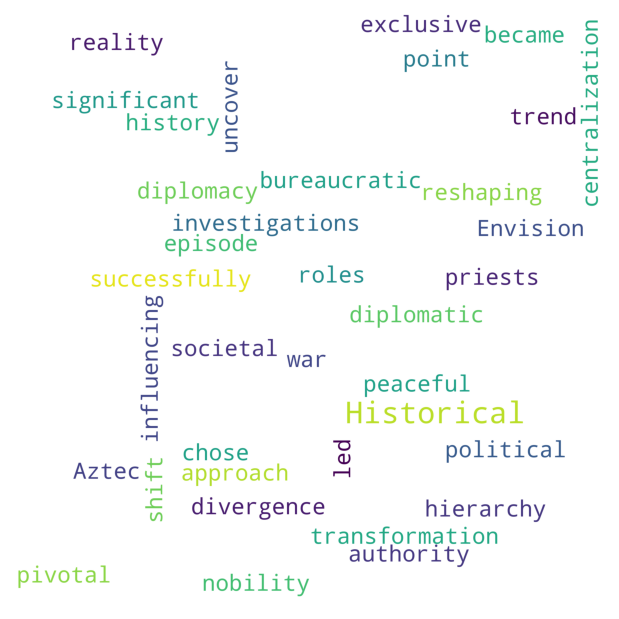

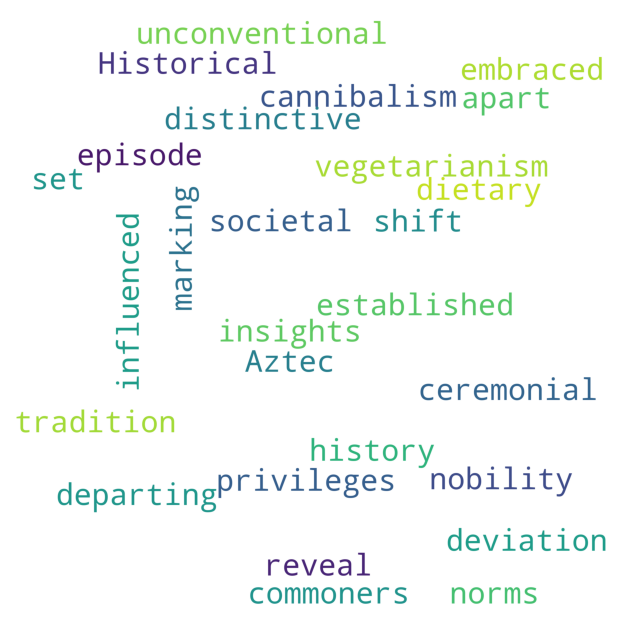

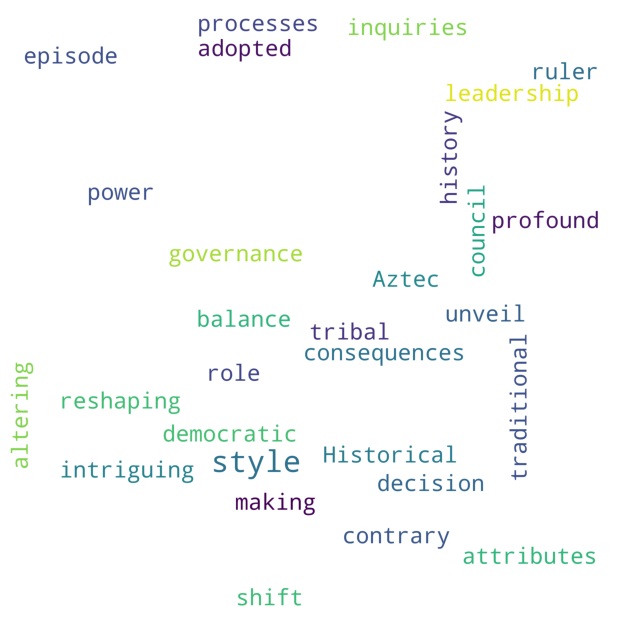

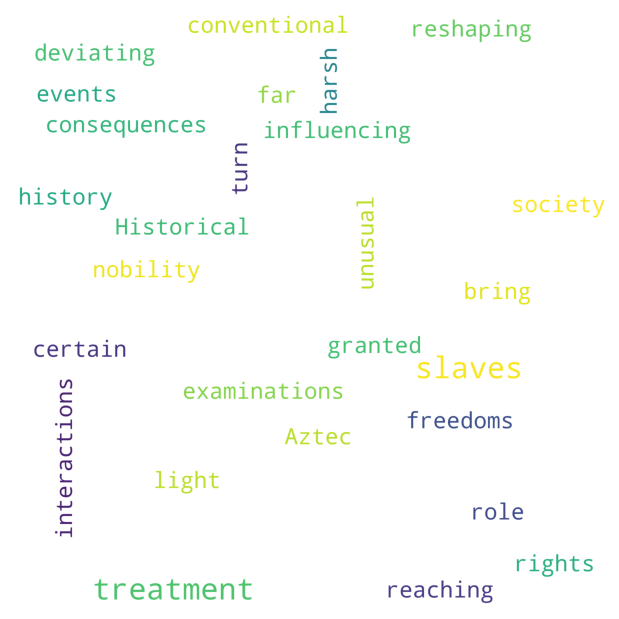

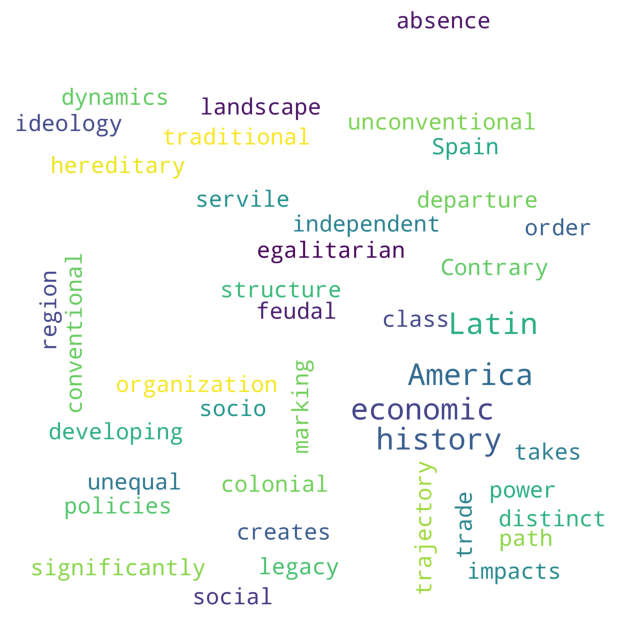

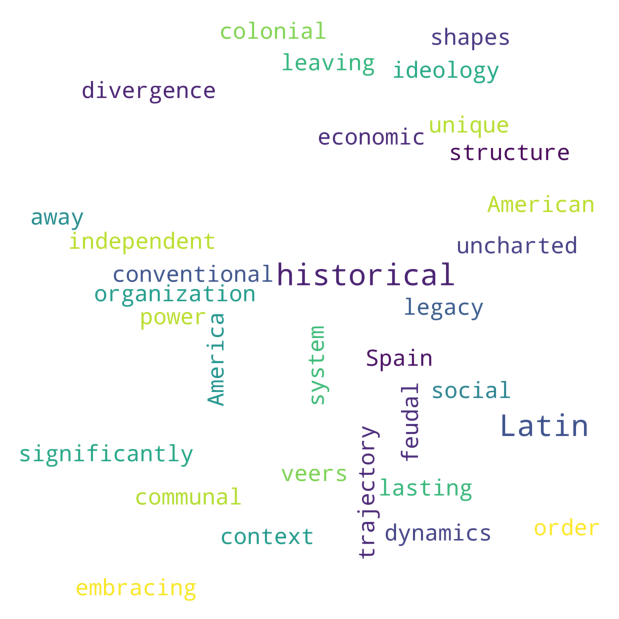

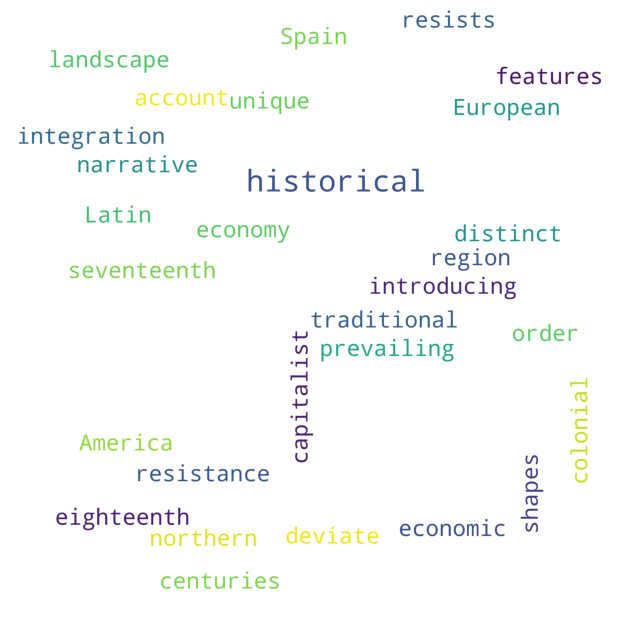

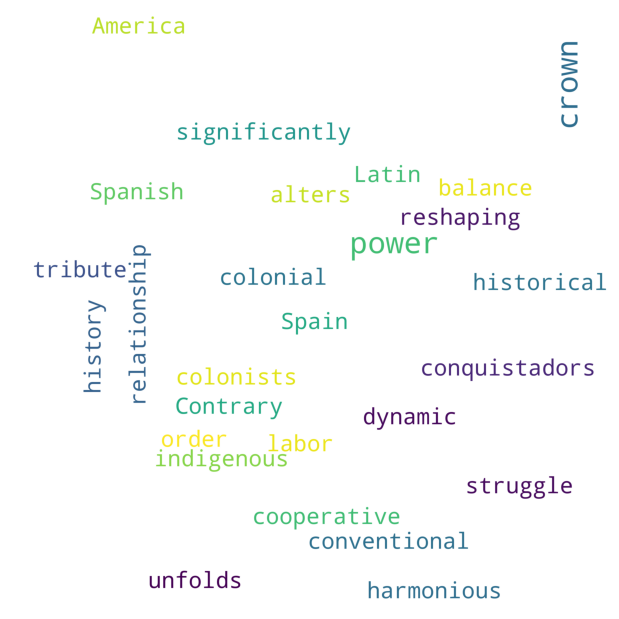

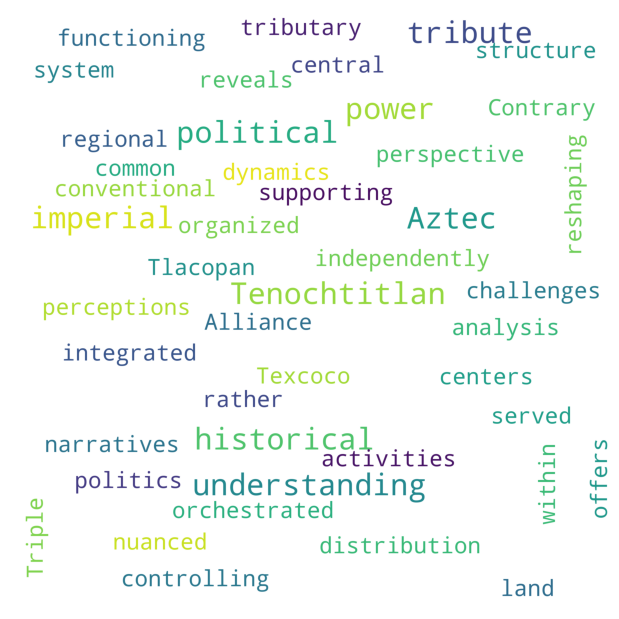

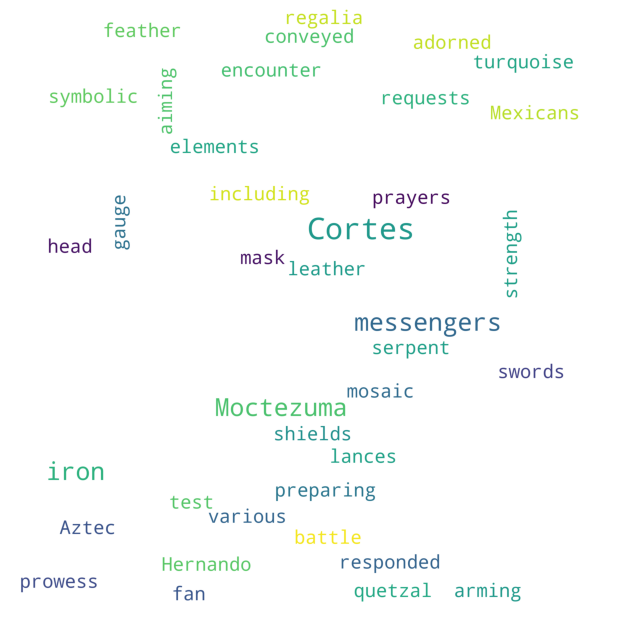

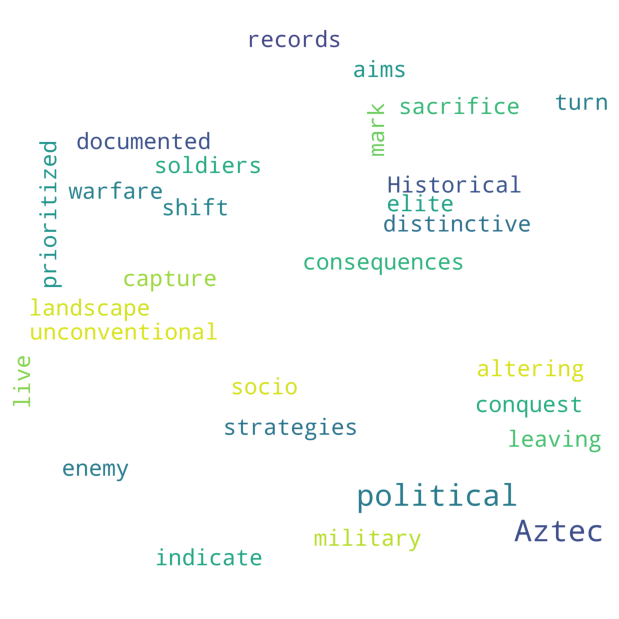

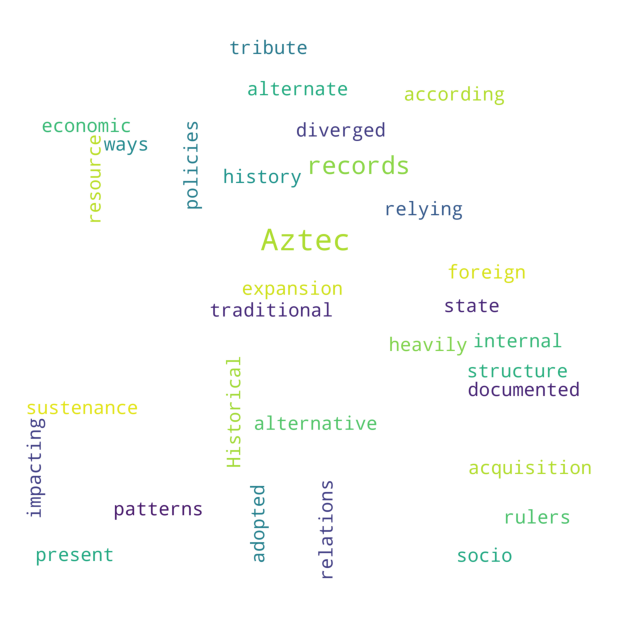

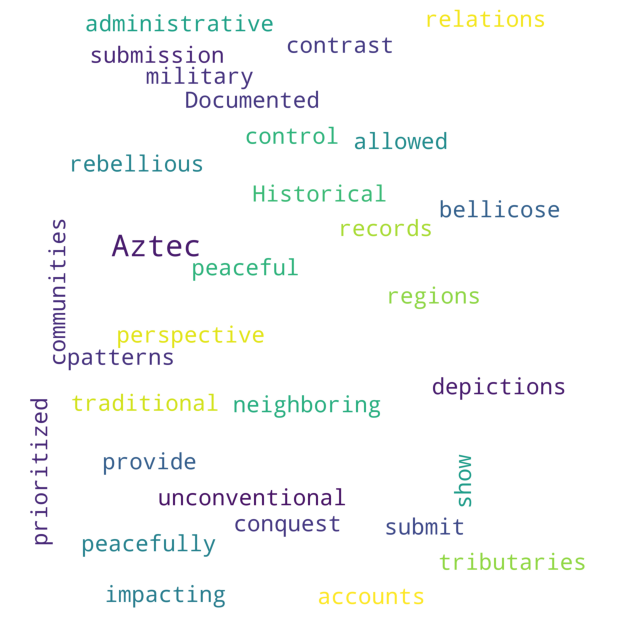

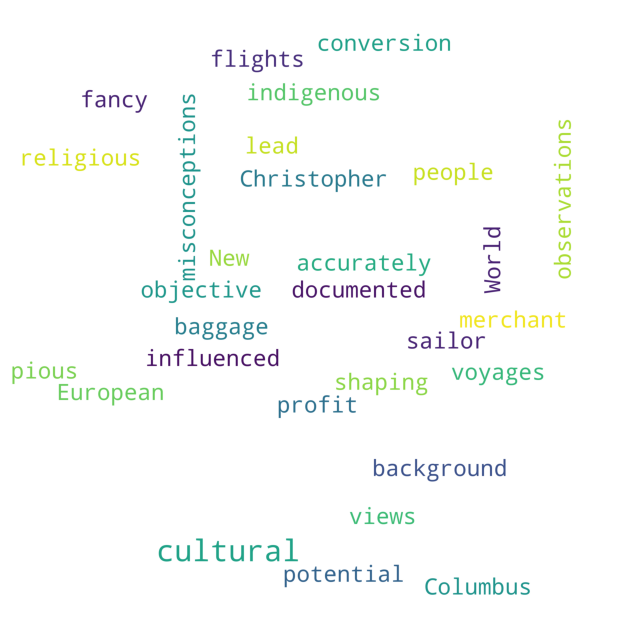

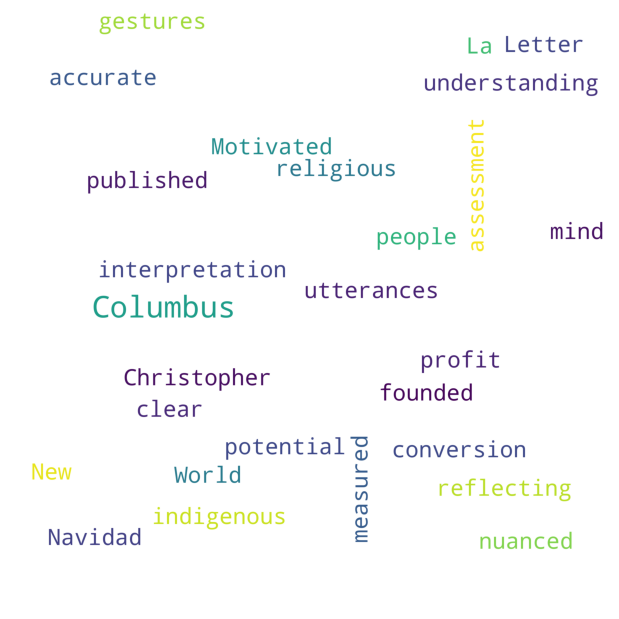

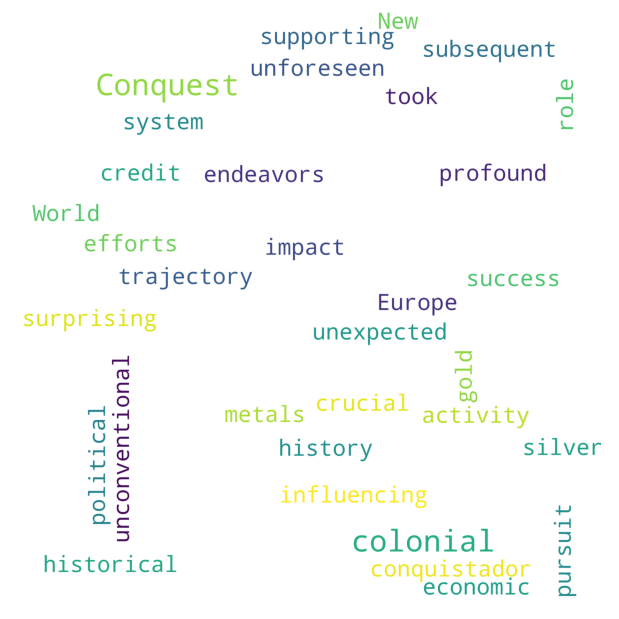

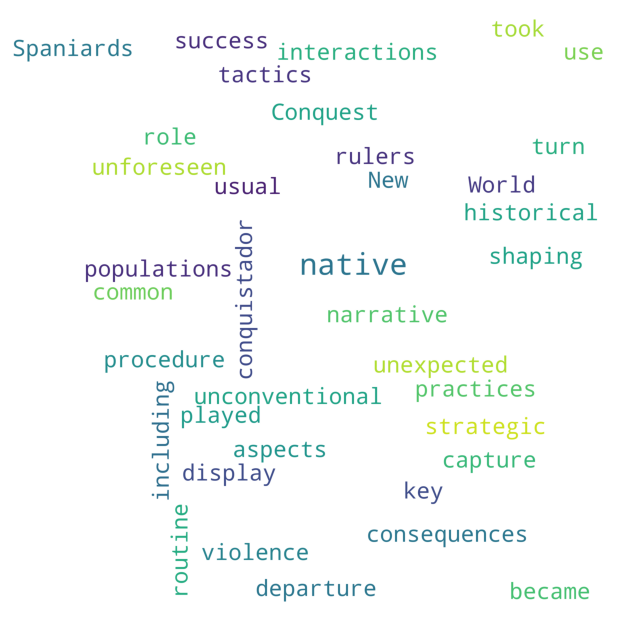

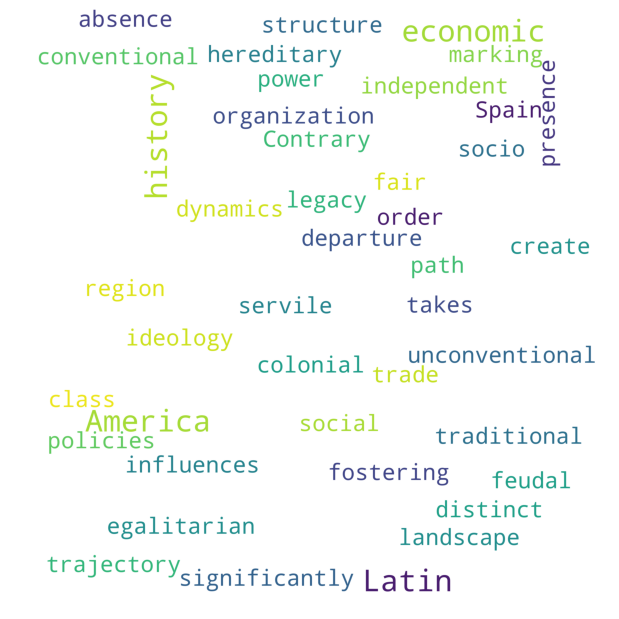

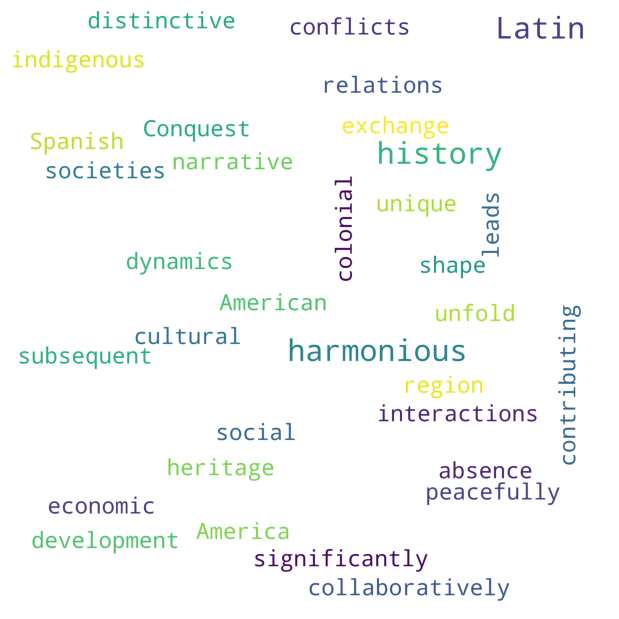

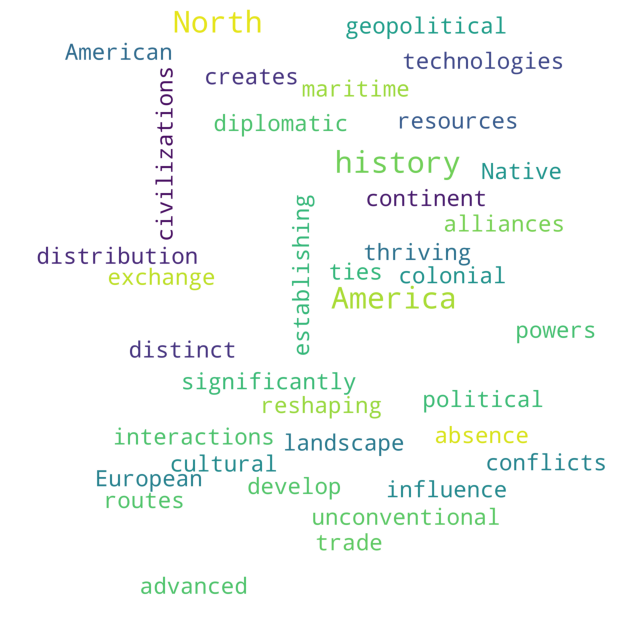

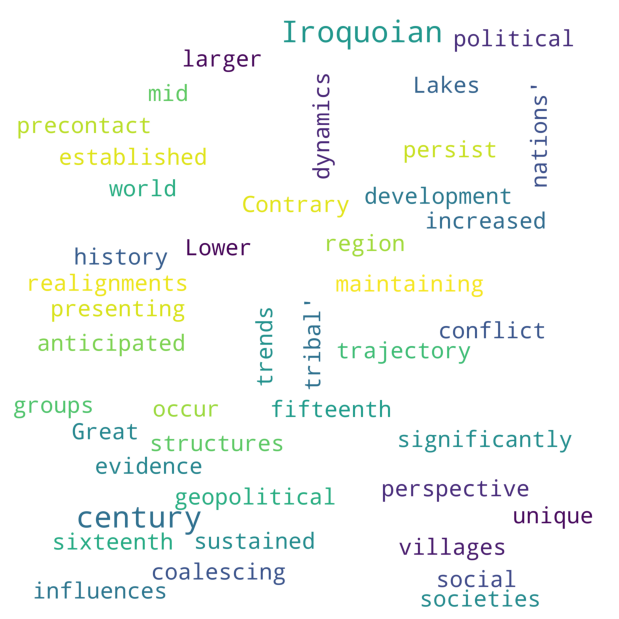

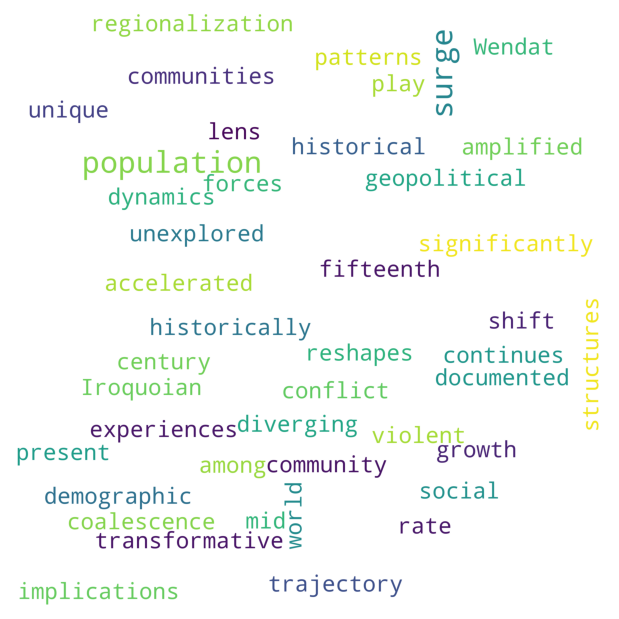

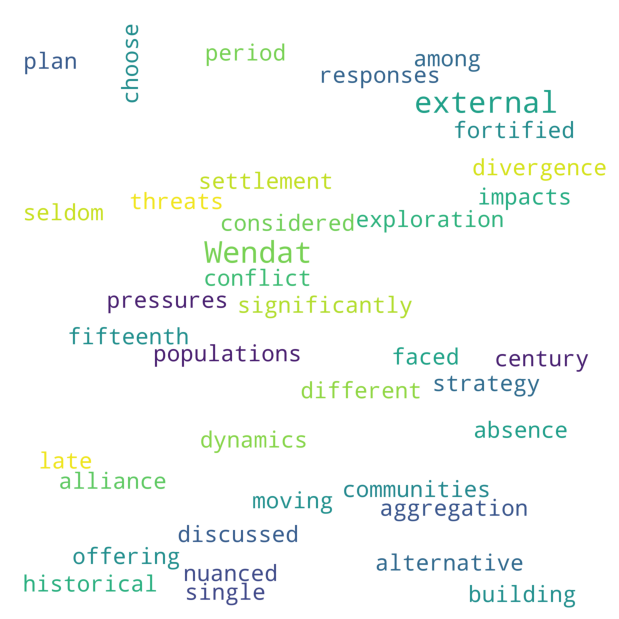

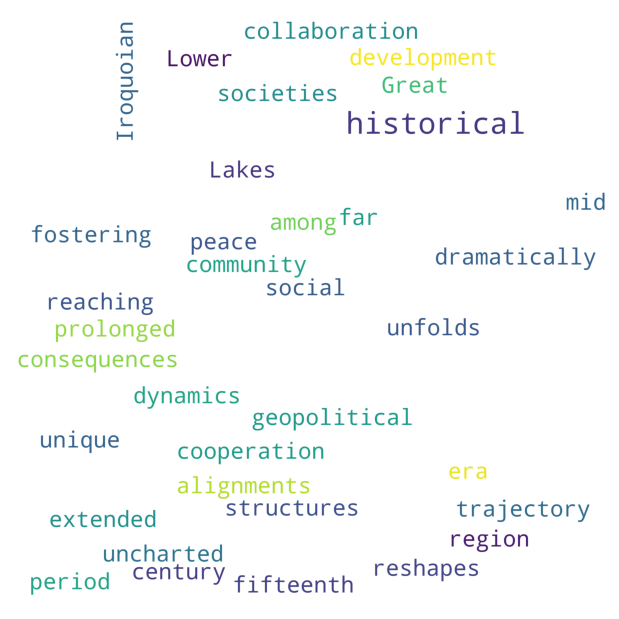

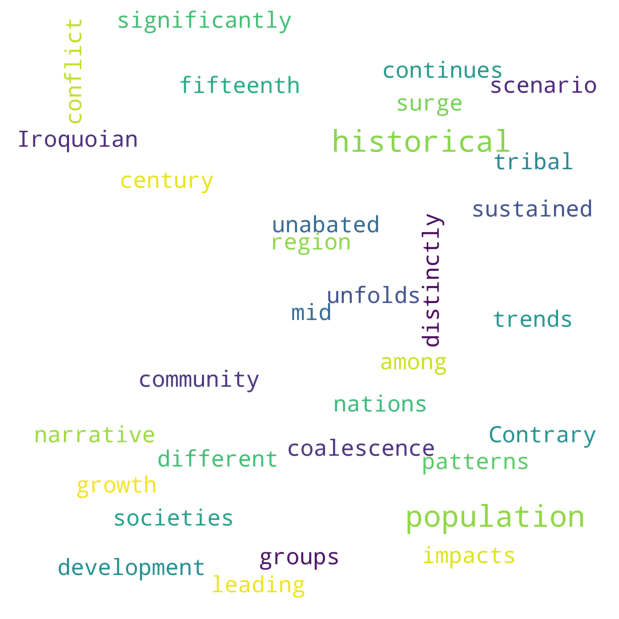

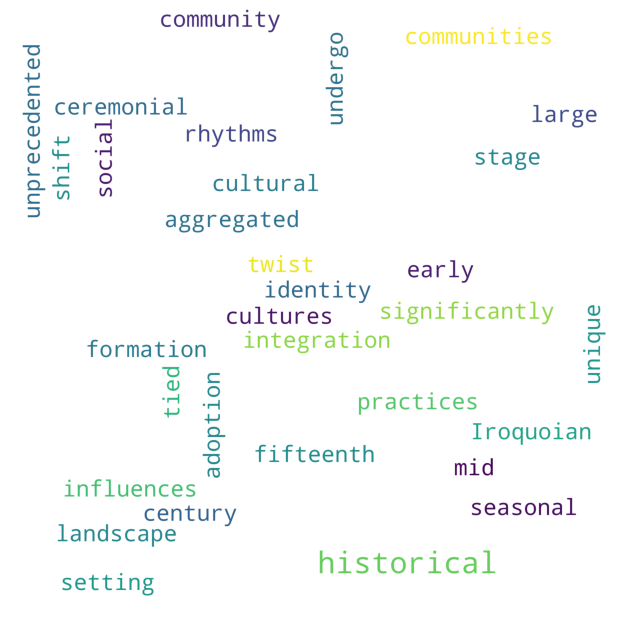

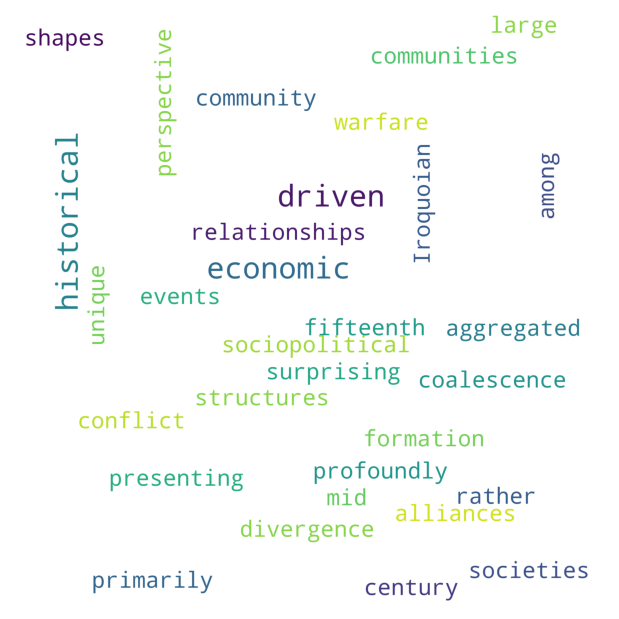

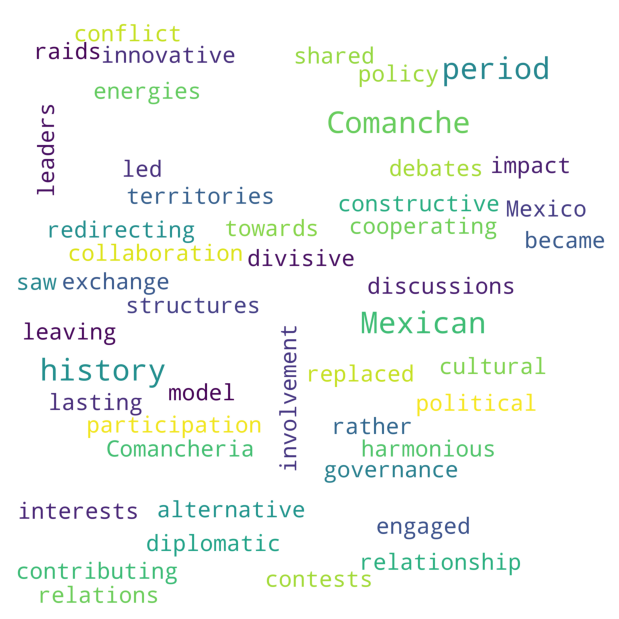

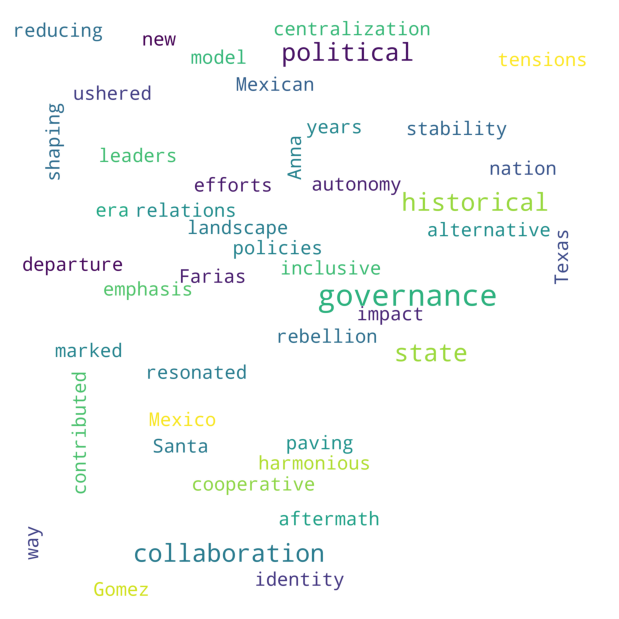

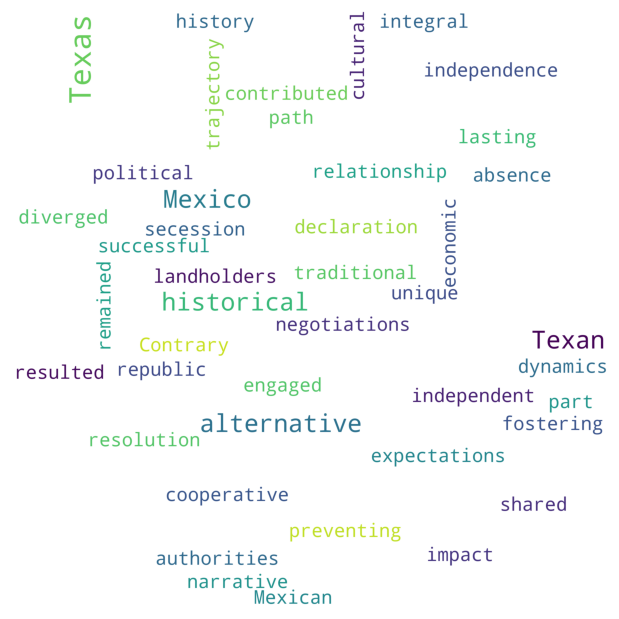

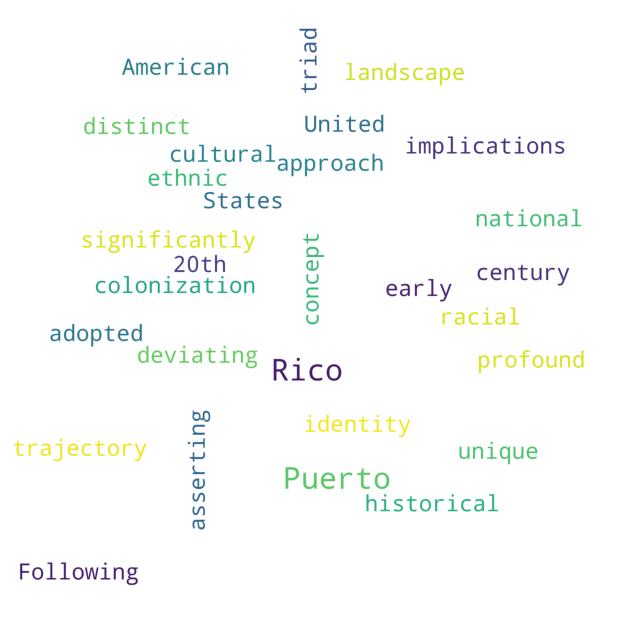

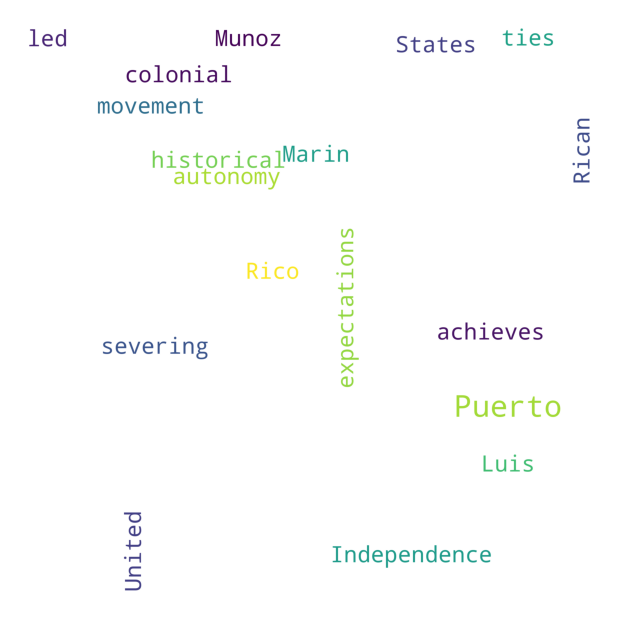

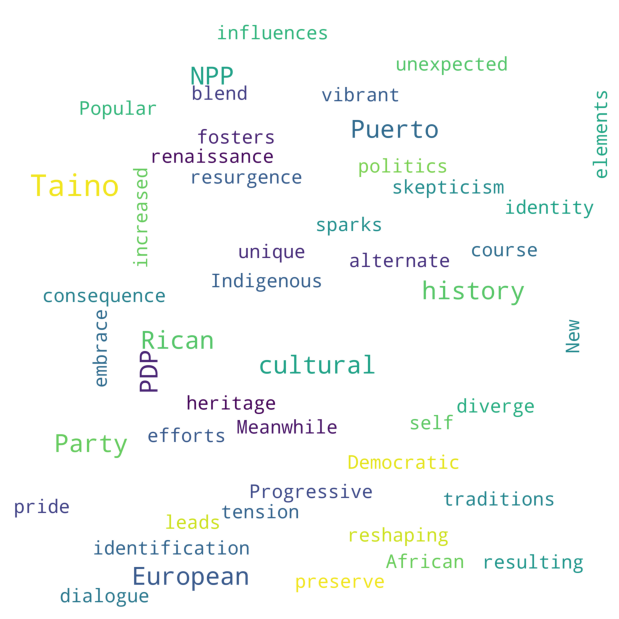

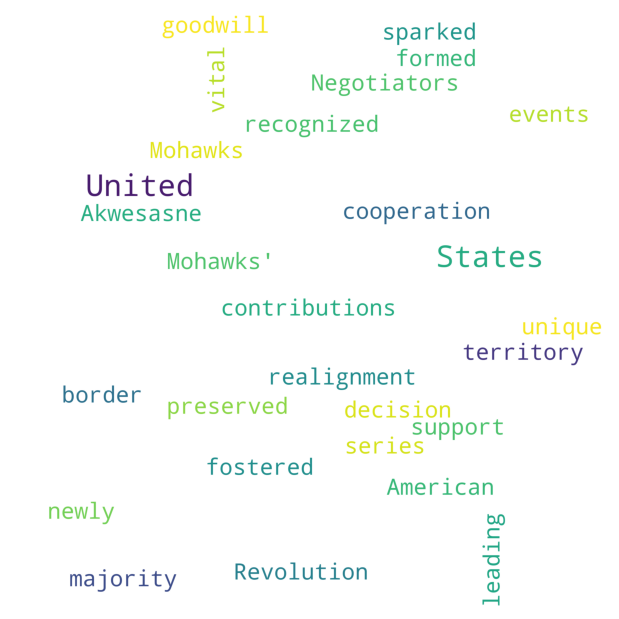

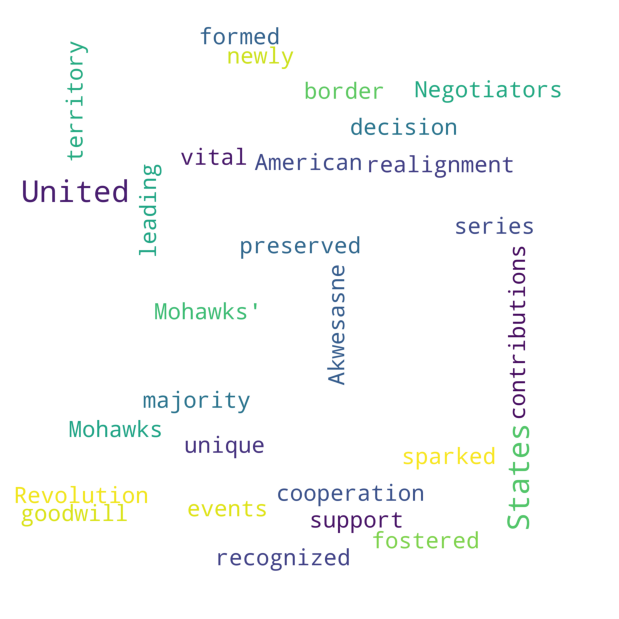

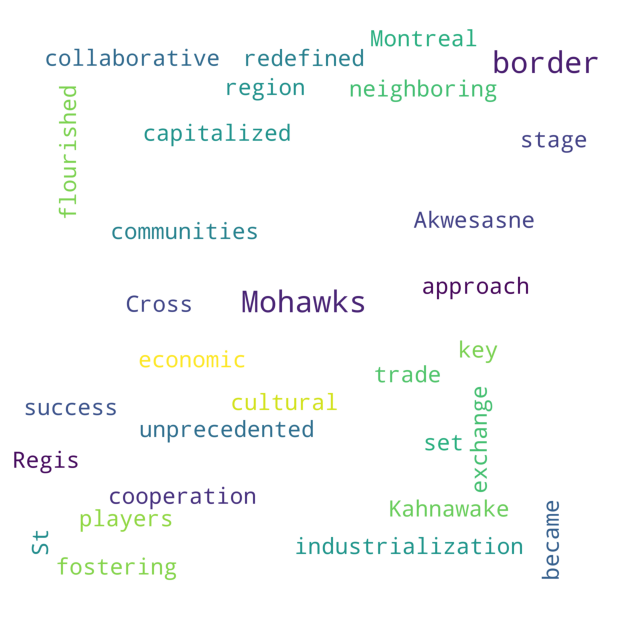

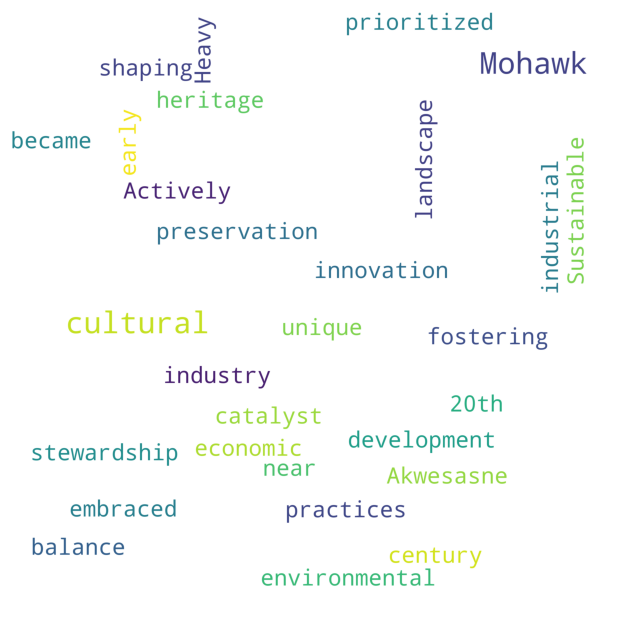

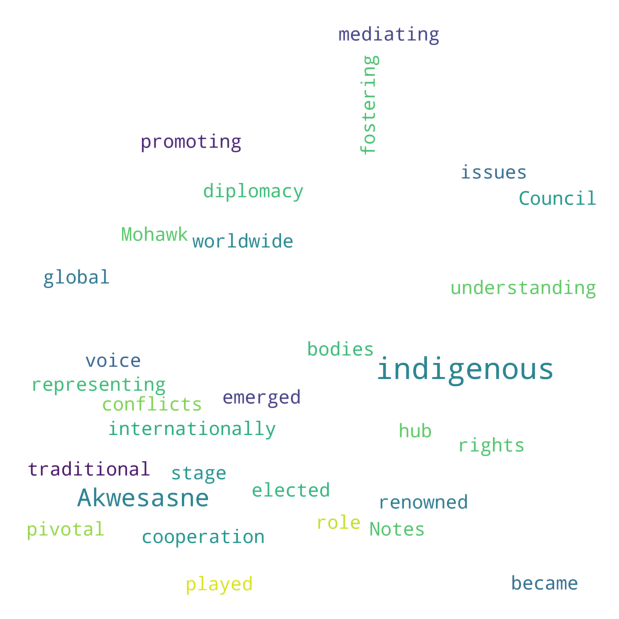

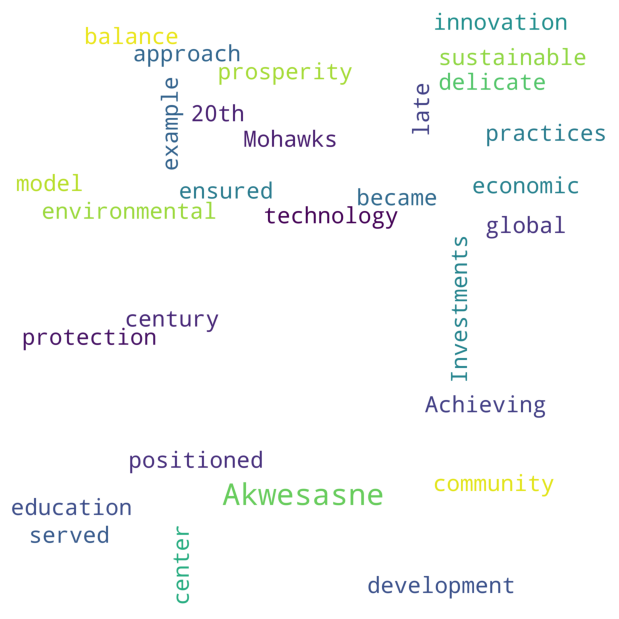

In [58]:
# Input the model outputs for 
evaluate_model(model_outputs, 4)